In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras import layers, models, Sequential
from datetime import timedelta
from scipy import stats as scipy_stats
import io
import base64
import os

plt.rcParams.update(
    {
        "grid.linewidth": 0.5,
        "grid.alpha": 0.5,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "font.size": 10,  # base font size
        "axes.titlesize": 12,  # axes title
        "axes.labelsize": 10,  # axes labels
        "xtick.labelsize": 10,  # x tick labels
        "ytick.labelsize": 10,  # y tick labels
        "legend.fontsize": 10,  # legend
        "figure.titlesize": 12,  # figure title
    }
)


## 1.1  Data loading

**Subtask**:
Load the dataset "FullDayWithAlarms.xlsx" into a pandas DataFrame.


The data seems to have a header in the first row.  The next step is to read the data correctly, skipping the first row and setting the columns to English.

In [15]:
raw_df = pd.read_excel("./data/FullDayWithAlarms.xlsx", header=1)
raw_df
# Rename columns for clarity
raw_df.rename(
    columns={
        "COD \nGIOCO": "Code_ID",
        "DATA ORA": "Timestamp",
        "INTERVALLO\nACQUISIZIONE": "Interval_s",
        "NUMERO\nTRANSAZIONI": "Num_Transactions",
        "TEMPO MIN": "Time_Min",
        "TEMPO MAX": "Time_Max",
        "TEMPO MEDIO": "Mean_Time",
        "NUMERO RETRY": "Num_Retries",
        "NUMERO \nTRANSAZIONI ERRATE": "Num_Wrong_Transactions",
    },
    inplace=True,
)

# # Parse and sort timestamps
raw_df["Timestamp"] = pd.to_datetime(
    raw_df["Timestamp"], dayfirst=True, errors="coerce"
)
raw_df.sort_values("Timestamp", inplace=True)
raw_df.reset_index(drop=True, inplace=True)

In [2]:
raw_df

Code_ID           Timestamp  Interval_s  Num_Transactions  Time_Min  \
0           8 2024-05-31 07:01:11          60               366         6   
1           8 2024-05-31 07:02:11          60               948         7   
2           8 2024-05-31 07:03:11          60              1273         7   
3           8 2024-05-31 07:04:11          60              1538         6   
4           8 2024-05-31 07:05:11          60               703         5   
...       ...                 ...         ...               ...       ...   
1013        8 2024-05-31 23:55:23          60              1061         3   
1014        8 2024-05-31 23:56:23          60               974         3   
1015        8 2024-05-31 23:57:23          60               995         4   
1016        8 2024-05-31 23:58:23          60               936         3   
1017        8 2024-05-31 23:59:23          60               861         4   

      Time_Max  Mean_Time  Num_Retries  Num_Wrong_Transactions  
0         1019  25.907562            0                      90  
1           90  18.181719            0                      90  
2          408  18.813356            0                      90  
3           70  16.607435            0                      90  
4           85  16.645409            0                      90  
...        ...        ...          ...                     ...  
1013        83  10.171293            0                     167  
1014        53  10.172589            0                     185  
1015        55   9.933611            0                     141  
1016        39  10.171029            0                     196  
1017        48   9.897042            0                     150  

[1018 rows x 9 columns]

In [3]:
# Quick summary and missing values
print("Dataset shape:", raw_df.shape)
print("\nMissing values per column:")
raw_df.isnull().sum()

Dataset shape: (1018, 9)

Missing values per column:


Code_ID                   0
Timestamp                 0
Interval_s                0
Num_Transactions          0
Time_Min                  0
Time_Max                  0
Mean_Time                 0
Num_Retries               0
Num_Wrong_Transactions    0
dtype: int64

In [4]:
raw_df.describe()

Code_ID                      Timestamp  Interval_s  Num_Transactions  \
count   1018.0                           1018      1018.0       1018.000000   
mean       8.0  2024-05-31 15:30:13.430255616        60.0       2245.859528   
min        8.0            2024-05-31 07:01:11        60.0        204.000000   
25%        8.0            2024-05-31 11:15:37        60.0       1424.750000   
50%        8.0            2024-05-31 15:30:09        60.0       2323.000000   
75%        8.0            2024-05-31 19:44:54        60.0       3007.000000   
max        8.0            2024-05-31 23:59:23        60.0       5057.000000   
std        0.0                            NaN         0.0       1136.991871   

          Time_Min      Time_Max    Mean_Time  Num_Retries  \
count  1018.000000   1018.000000  1018.000000  1018.000000   
mean      2.737721   1346.666994    49.715493    89.292731   
min       0.000000     28.000000     9.462604     0.000000   
25%       3.000000     82.000000    11.039727     0.000000   
50%       3.000000    124.000000    12.349440     0.000000   
75%       3.000000    232.500000    13.582763     0.000000   
max       7.000000  92682.000000  2019.271700  6496.000000   
std       0.934939   7207.947520   182.782991   599.256239   

       Num_Wrong_Transactions  
count             1018.000000  
mean               155.943026  
min                 81.000000  
25%                122.250000  
50%                149.000000  
75%                186.000000  
max                448.000000  
std                 47.440950

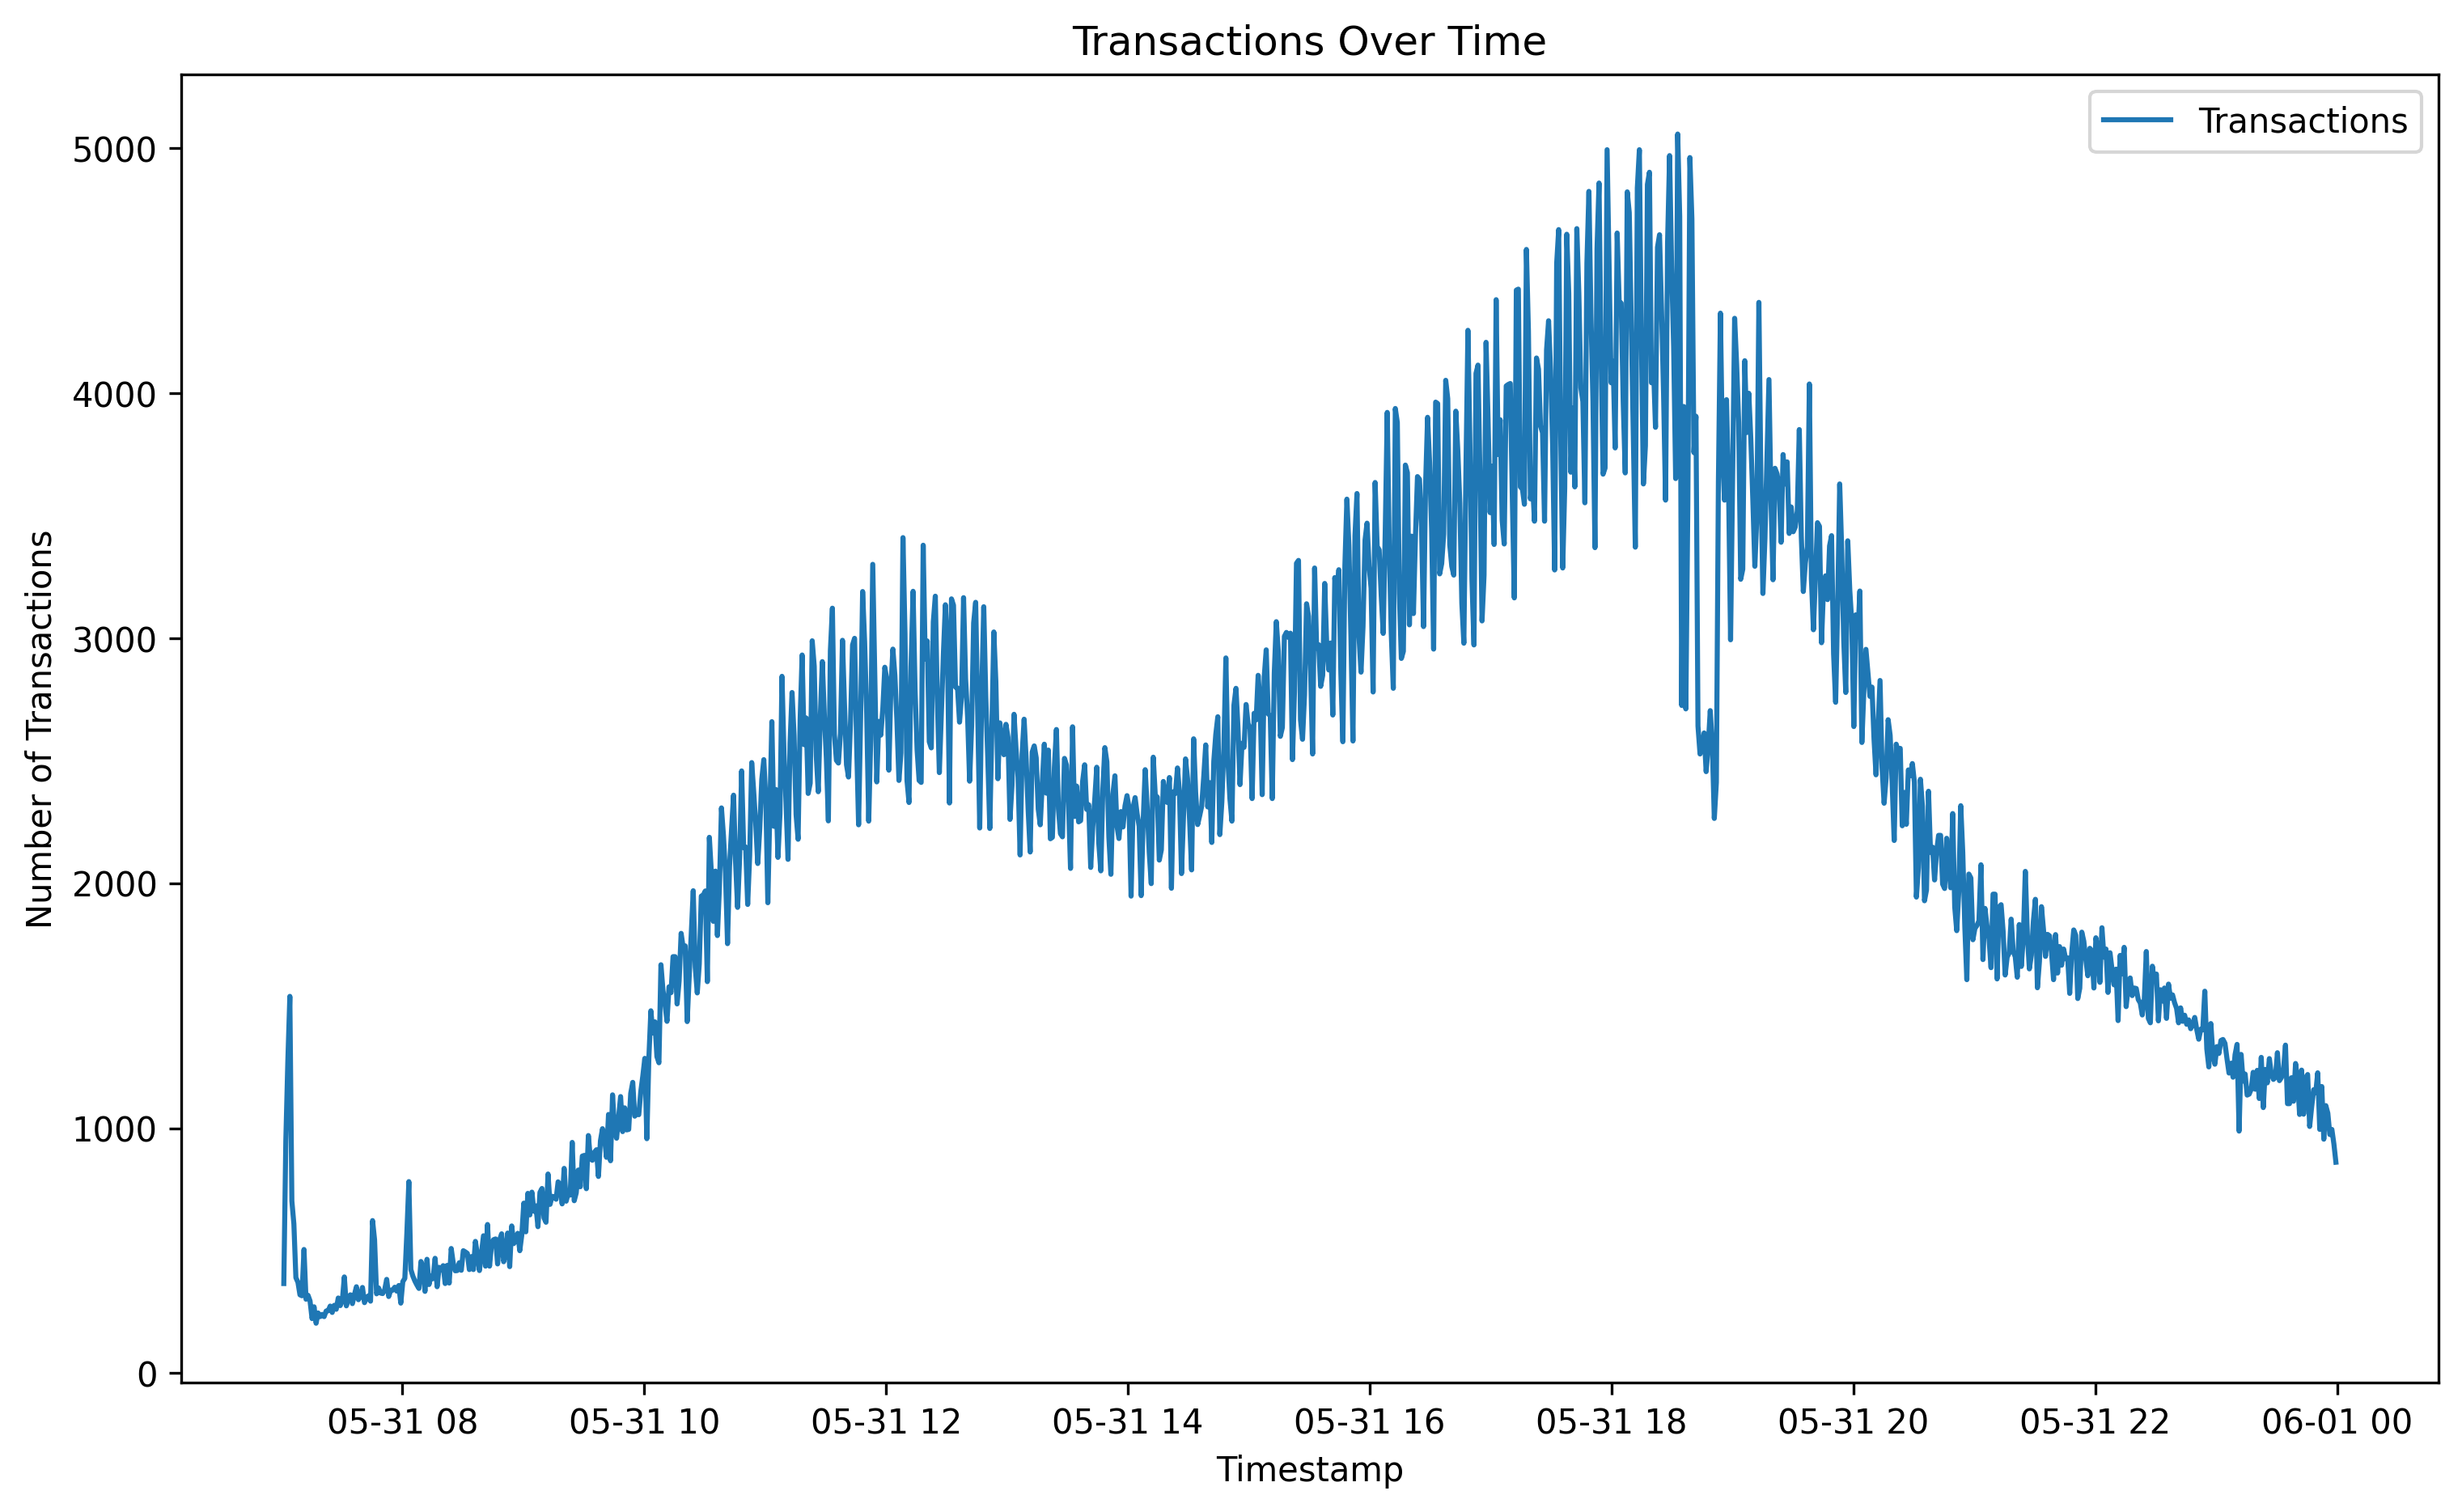

In [5]:
# 6. Plot key time series
plt.plot(raw_df['Timestamp'], raw_df["Num_Transactions"], label="Transactions")
plt.xlabel("Timestamp")
plt.ylabel("Number of Transactions")
plt.title("Transactions Over Time")
plt.legend()
plt.savefig("./images/00-transactions_over_time_original_data.png")

In [6]:
records_per_day = raw_df.shape[0] 
records_per_day

1018

# 0 Dataset

This dataset contains transaction data from a system, recorded over the course of one day. The information is captured in 60-second intervals. For each interval, the dataset includes:

- The number of transactions that occurred

- The minimum, maximum, and average processing time for the transactions

- The number of retries the system performed to successfully process transactions

- The number of failed transactions that were not submitted successfully

Our final goal is to develop an anomaly detection system. This system should be able to take a current time interval, predict transaction behavior in the near future, and apply anomaly detection techniques to the predicted values in order to identify unusual or abnormal transaction patterns.


# 1 Data Analysis

Before starting to develope our prediction and detection models, we have to obtain knowledge about the nature of the provided dataset with the given attributes.We will analyze the dataset structure to identify trends and see if there are any increasing or decreasing patterns over the day or not.

 - Seasonality: Are there any recurring patterns at specific times of the day (e.g., higher transaction volume during business hours)?
 - Stationarity: Does the statistical properties of the time series (mean, variance) remain constant over time?
 - Outliers: Are there any unusual spikes or drops in the values that might indicate anomalies?

We will also examine the distribution of each numerical variable using histograms or kernel density plots. This will give us insights into the typical range of values and the presence of any skewness.

## 1.2 Basic Plots

### Subtask:
In this section we want to explore the dataset to understand its basic characteristics, including data shape, types, missing values, numerical feature analysis, and potential outliers.
The histograms visualize the distributions of numerical features, helping to identify potential outliers and skewness


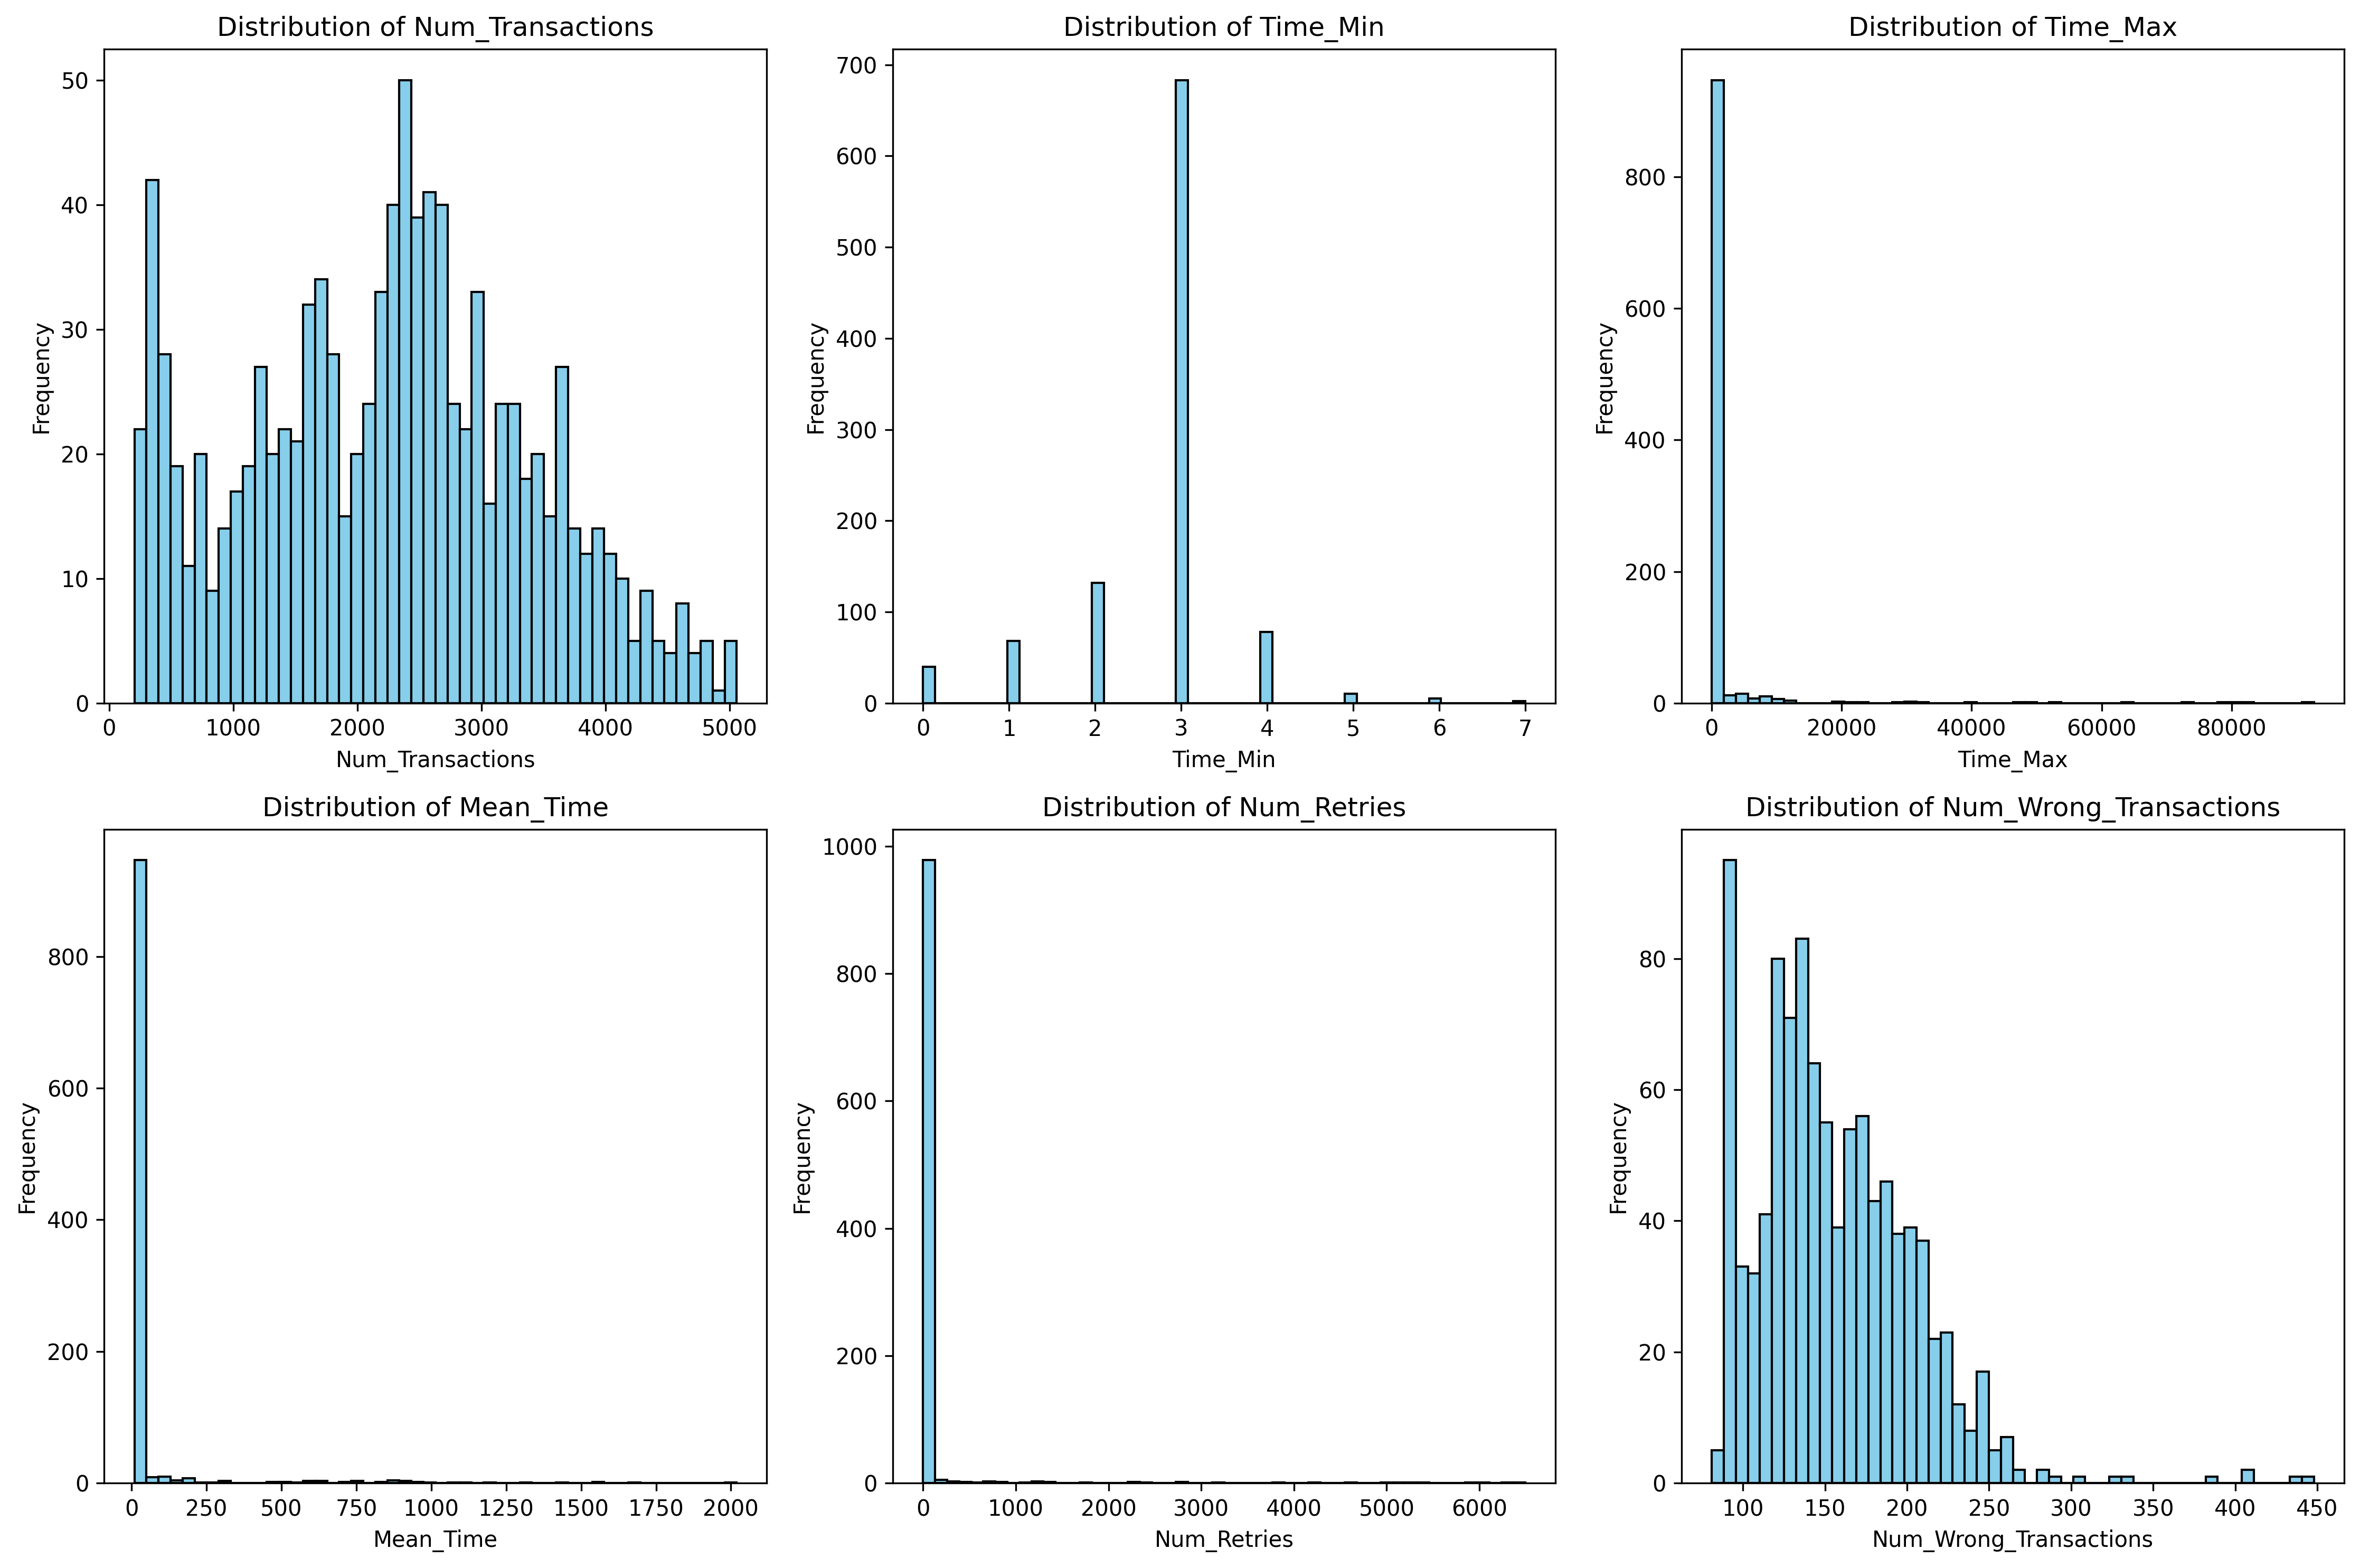

Data Shape: (1018, 9)

Data Types:
 Code_ID                            int64
Timestamp                 datetime64[ns]
Interval_s                         int64
Num_Transactions                   int64
Time_Min                           int64
Time_Max                           int64
Mean_Time                        float64
Num_Retries                        int64
Num_Wrong_Transactions             int64
dtype: object

Missing Values:
 Code_ID                   0
Timestamp                 0
Interval_s                0
Num_Transactions          0
Time_Min                  0
Time_Max                  0
Mean_Time                 0
Num_Retries               0
Num_Wrong_Transactions    0
dtype: int64

Descriptive Statistics for Numerical Features:
        Num_Transactions     Time_Min      Time_Max    Mean_Time  Num_Retries  \
count       1018.000000  1018.000000   1018.000000  1018.000000  1018.000000   
mean        2245.859528     2.737721   1346.666994    49.715493    89.292731   
std      

In [18]:
# Data Shape and Types
data_shape = raw_df.shape
data_types = raw_df.dtypes

# Missing Values
missing_values =  raw_df.isnull().sum()

# Feature Analysis
numerical_features = ['Num_Transactions', 'Time_Min', 'Time_Max', 'Mean_Time', 'Num_Retries', 'Num_Wrong_Transactions']
descriptive_stats =  raw_df[numerical_features].describe()

# Data Distribution and Potential Outliers (Histograms)

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    plt.hist( raw_df[col], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("./images/00-histograms-of-variables.png")
plt.show()

# Document Findings
print("Data Shape:", data_shape)
print("\nData Types:\n", data_types)
print("\nMissing Values:\n", missing_values)
print("\nDescriptive Statistics for Numerical Features:\n", descriptive_stats)

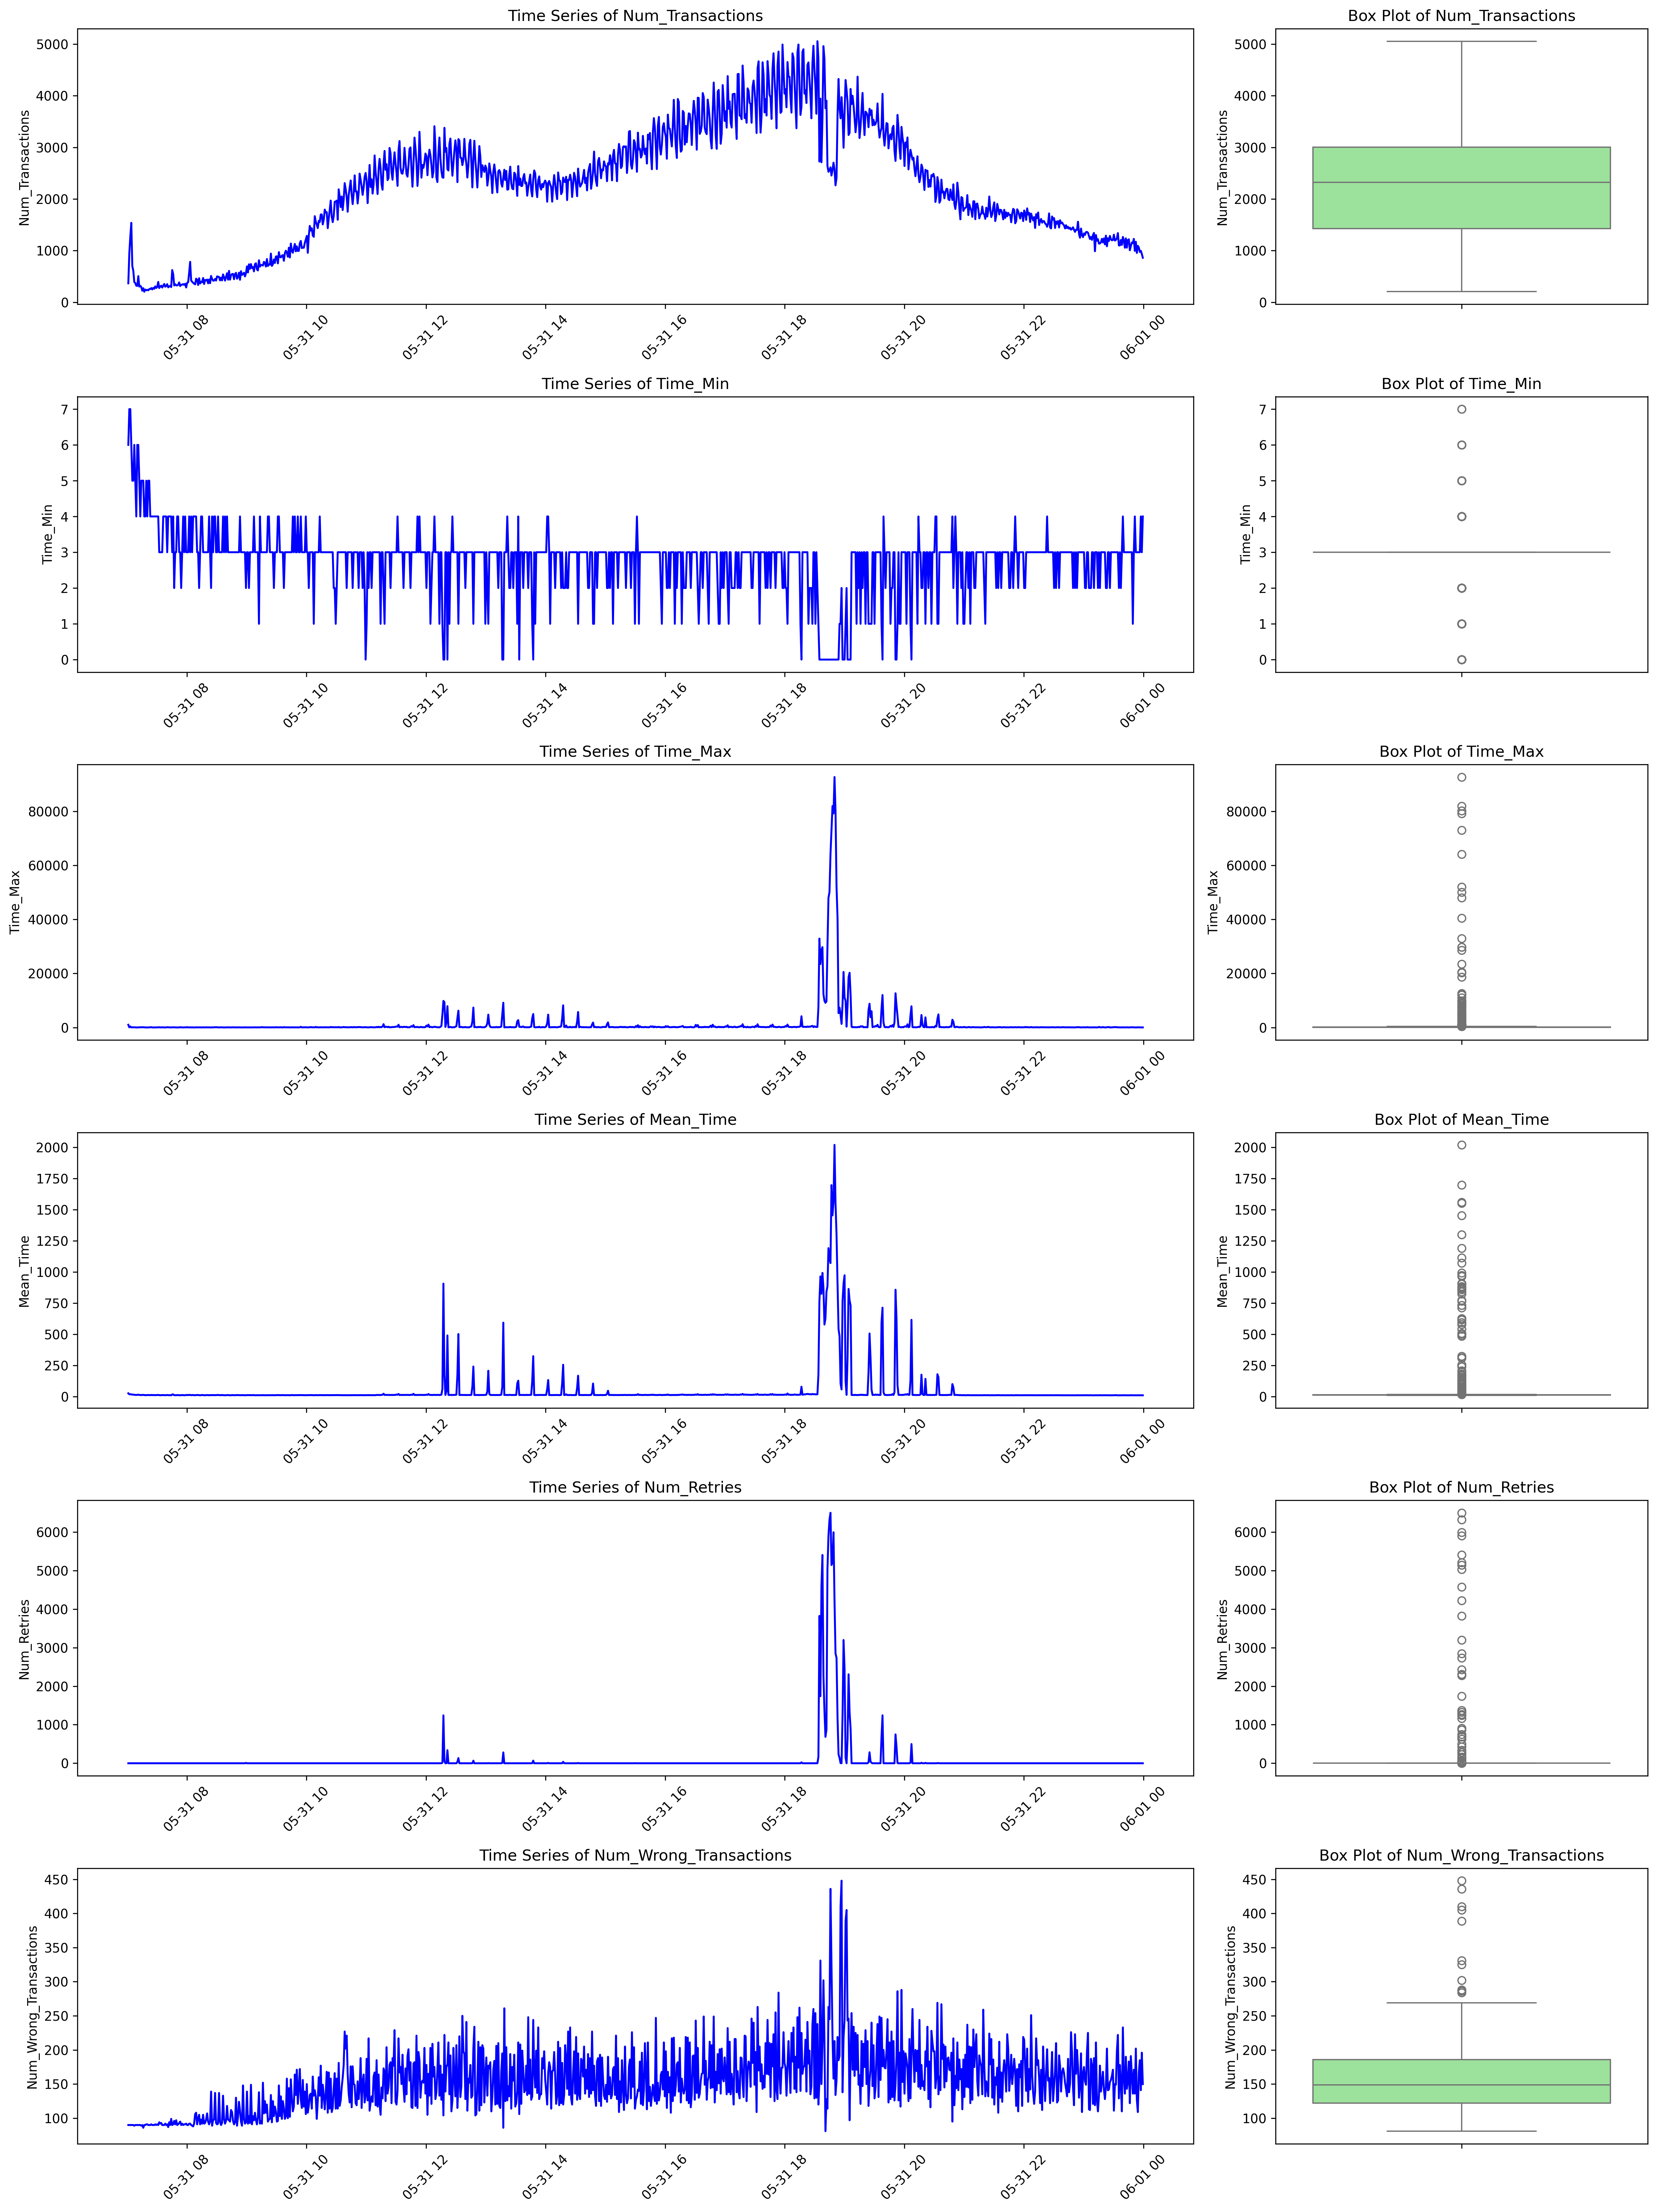

In [19]:
#time series plots for observing normal and unusual patterns

fig, axs = plt.subplots(len(numerical_features), 2, figsize=(18, 4 * len(numerical_features)), 
                       gridspec_kw={'width_ratios': [3, 1]})

for i, feature in enumerate(numerical_features):
    # Time series plot
    axs[i, 0].plot(raw_df['Timestamp'], raw_df[feature], color='blue')
    axs[i, 0].set_title(f'Time Series of {feature}')
    
    axs[i, 0].set_ylabel(feature)
    axs[i, 0].tick_params(axis='x', rotation=45)
    
    # Rotated (vertical) box plot
    sns.boxplot(y=raw_df[feature], ax=axs[i, 1], color='lightgreen', orient='v')
    axs[i, 1].set_title(f'Box Plot of {feature}')
    axs[i, 1].set_ylabel(feature)

plt.tight_layout()
plt.savefig("./images/01-time-series-and-boxplots.png")

The **box plot of `Num_Transactions`** helps detect any unusual spikes in transaction counts that could point to system stress or unexpected user behavior. From the plot, we observe that the number of transactions generally ranges between approximately 1000 and 3000. However, there are several high outliers, with some intervals exceeding 5000 transactions. This indicates that while the system normally processes a moderate volume, there are certain periods with exceptionally high activity that may require further investigation.

The **box plot of `Time_Min`** was included to assess the shortest processing time recorded in each interval. This helps in identifying any unexpected low values that might indicate abnormalities in transaction handling. The plot shows that most minimum processing times are around 3 units, with a few lower outliers down to 0 or 1 and above 4. These low values could be artifacts of data collection or represent failed or incomplete transactions that bypassed the standard processing time. Interesting point about `Time_Min` is that whenever it is under 1, other metrics starts to spike or arise which can be a sign of being abnormal.

The **box plot of `Time_Max`** was used to capture the upper bound of transaction processing time in each interval. By analyzing this, we can detect performance bottlenecks or problematic transactions that take abnormally long to complete. The majority of values are tightly clustered near the bottom, suggesting that most transactions are processed within a reasonable timeframe. However, the plot reveals a large number of extreme outliers, with some maximum times exceeding 80,000 units. These spikes are clear red flags for performance issues and could signal underlying system failures or data anomalies during those intervals.

The **box plot of `Mean_Time`** provides insights into the average processing time per interval. This metric is essential for evaluating the system's overall efficiency and consistency. The box plot shows a tightly packed distribution near the lower end, indicating that most intervals have a low average transaction time. Nevertheless, a number of high outliers are present, with some intervals showing mean times above 1500 or even 2000 units. Such spikes could point to transient performance issues, congestion, or specific transactions that are disproportionately slowing down the system and can be seen as abnormal ones.

The **box plot of `Num_Retries`** was plotted to understand how frequently the system had to retry transactions. High retry counts can be symptomatic of instability, errors, or external service issues. The majority of the data is concentrated near zero retries, which is a positive indicator of system reliability. However, the presence of many high outliers—some exceeding 6000 retries in a single interval—indicates occasional severe disruptions that require attention. These anomalies may align with periods of heavy system load or technical malfunctions.

Lastly, the **box plot of `Num_Wrong_Transactions`** was used to examine how often transactions fail to complete successfully. Monitoring this variable is critical for ensuring service reliability and user satisfaction. The distribution shows that most values fall between 100 and 200, with a relatively moderate interquartile range. Nonetheless, several high outliers are present, with failed transactions reaching above 450 in some intervals. These failure spikes may correlate with the high retry rates and processing time anomalies seen in other plots, offering a potential direction for root-cause analysis.


## 1.3 EDA

In this section we visualize the relationships between variables using correlations, box and line plots to gain further insights.

We observed that the number of transactions over time does not follow a consistent trend. Instead, it fluctuates in a zigzag pattern between intervals. Additionally, we noticed that the amplitude of these fluctuations increases during specific times of the day, for example, between 10 AM and 1 PM, and peaks around 6 PM before starting to decline.

To better understand this behavior over time, we decided to plot the rolling variance of the number of transactions using a 15-minute window (i.e., 15 time intervals). This allows us to observe changes in variability throughout the day more clearly.

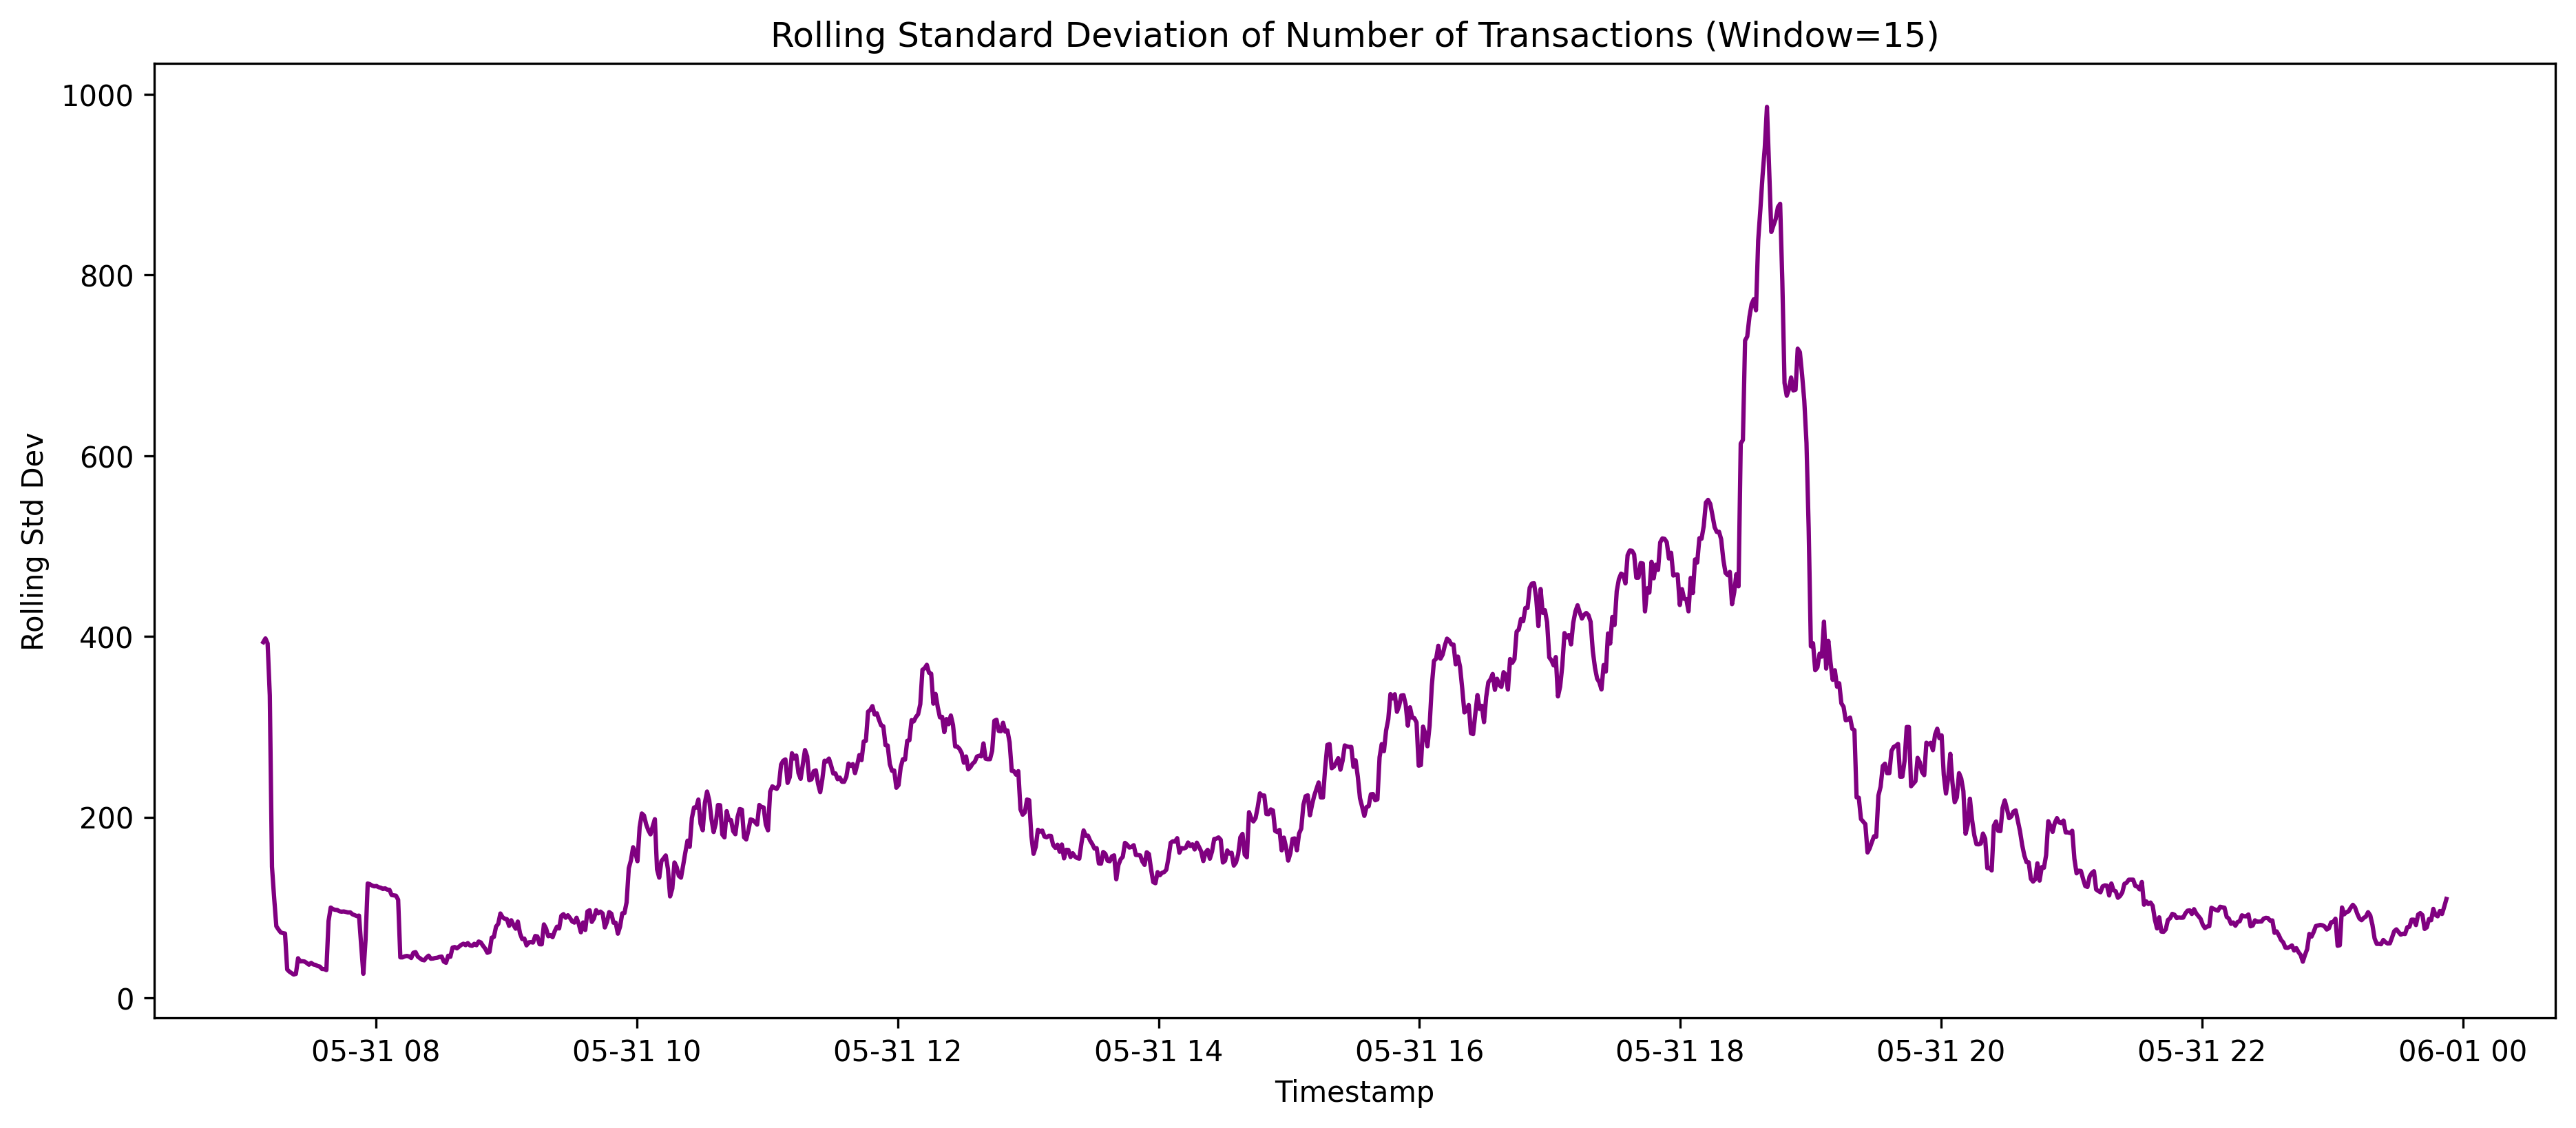

In [20]:
# Calculate the standard deviation for number of transactions over time

window=15 # 15 minutes rolling window
rolling_std = raw_df['Num_Transactions'].rolling(window=window).std()
rolling_std = rolling_std[14:]

# Plot the rolling standard deviation
plt.figure(figsize=(15, 6))
plt.plot(raw_df.iloc[7:-7]['Timestamp'], rolling_std, color='purple') # adjusting for the rolling window
plt.title(f'Rolling Standard Deviation of Number of Transactions (Window={window})')
plt.xlabel('Timestamp')
plt.ylabel('Rolling Std Dev')
plt.savefig(f"./images/02-rolling-standard-deviation.png")

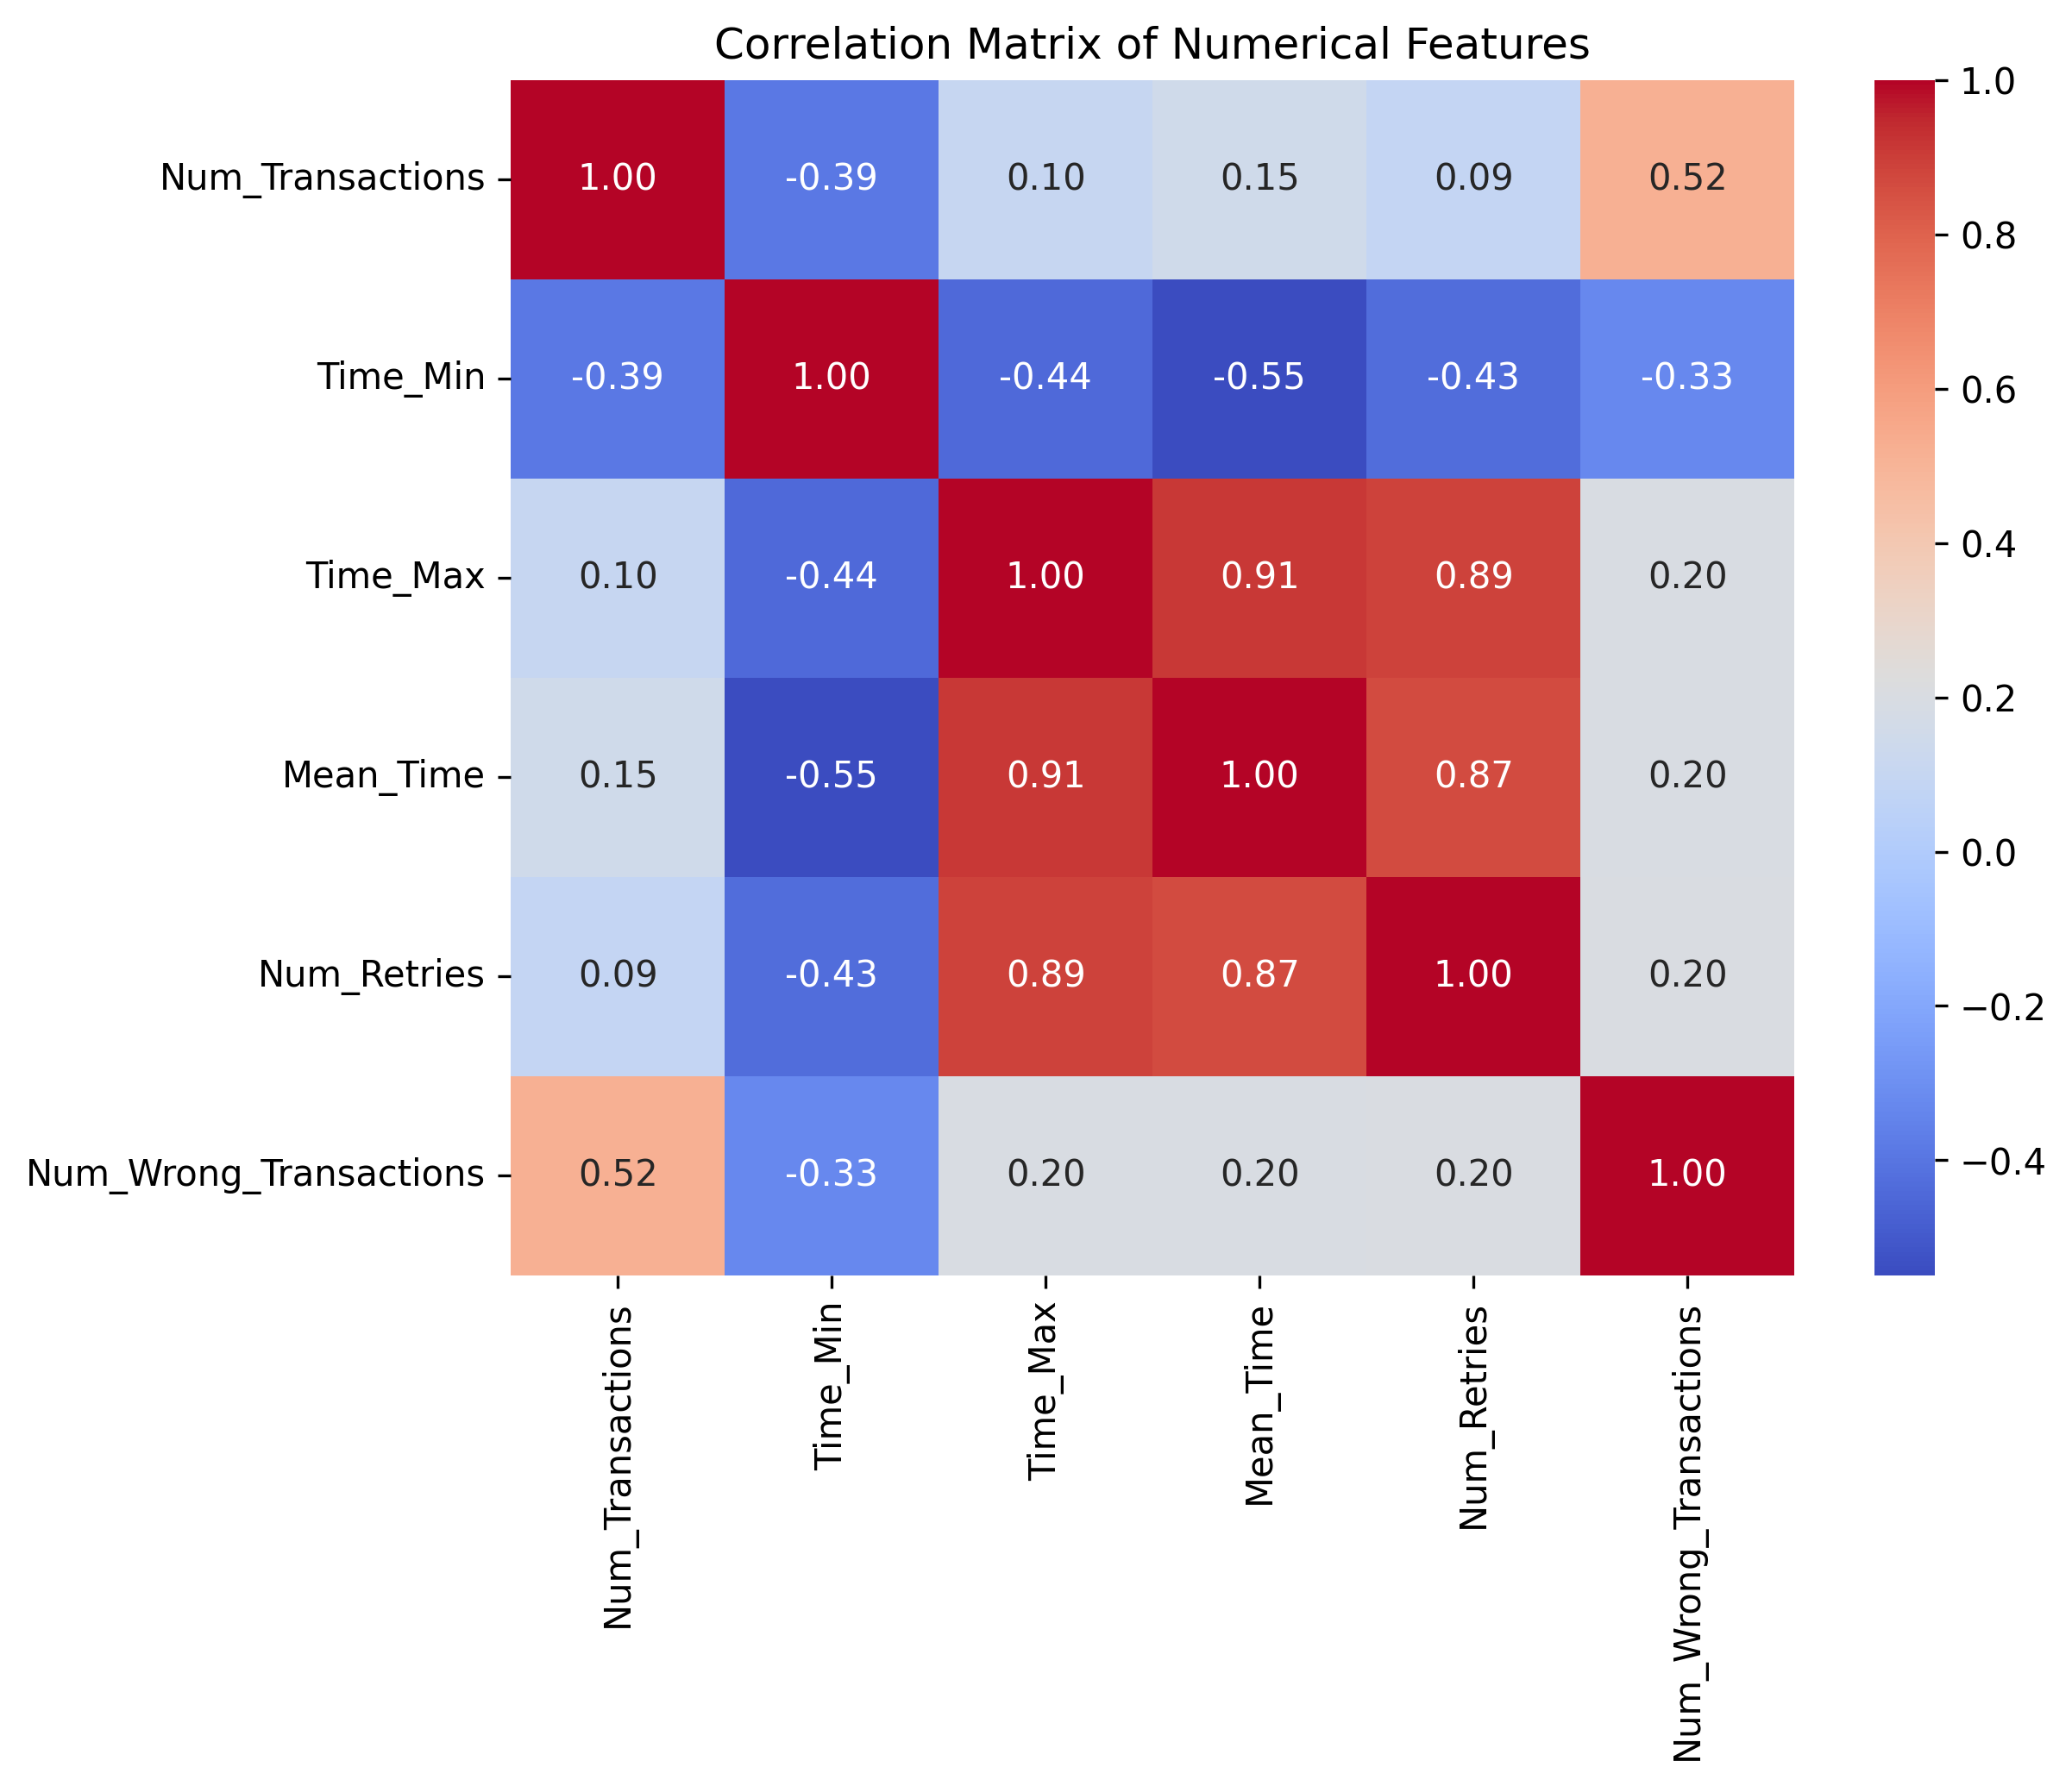

In [ ]:
# Correlation Analysis
plt.figure(figsize=(8, 6))
correlation_matrix = raw_df[['Num_Transactions', 'Time_Min', 'Time_Max', 'Mean_Time', 'Num_Retries', 'Num_Wrong_Transactions']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.savefig("./images/03-correlation-matrix.png")

It is notable that **`Time_Min` shows a moderate negative correlation with most other features**, particularly with `Mean_Time` (-0.55), `Time_Max` (-0.44), and `Num_Retries` (-0.43). This implies that when the minimum transaction time decreases, that happens mostly in crowded times of system to process the transactions faster, the overall system tends to perform worse, with more retries and higher average or maximum durations. To recap, lower `Time_Min` values are associated with more variability and potential instability in transaction processing.


This time series plot provides a view of the trends in three key variables: **`Num_Transactions`**, **`Mean_Time`**, and **`Time_Min`**, with smoothing techniques applied through a rolling window of size 10. The variables are visualized with different scaling to allow for meaningful comparisons on the same axis.

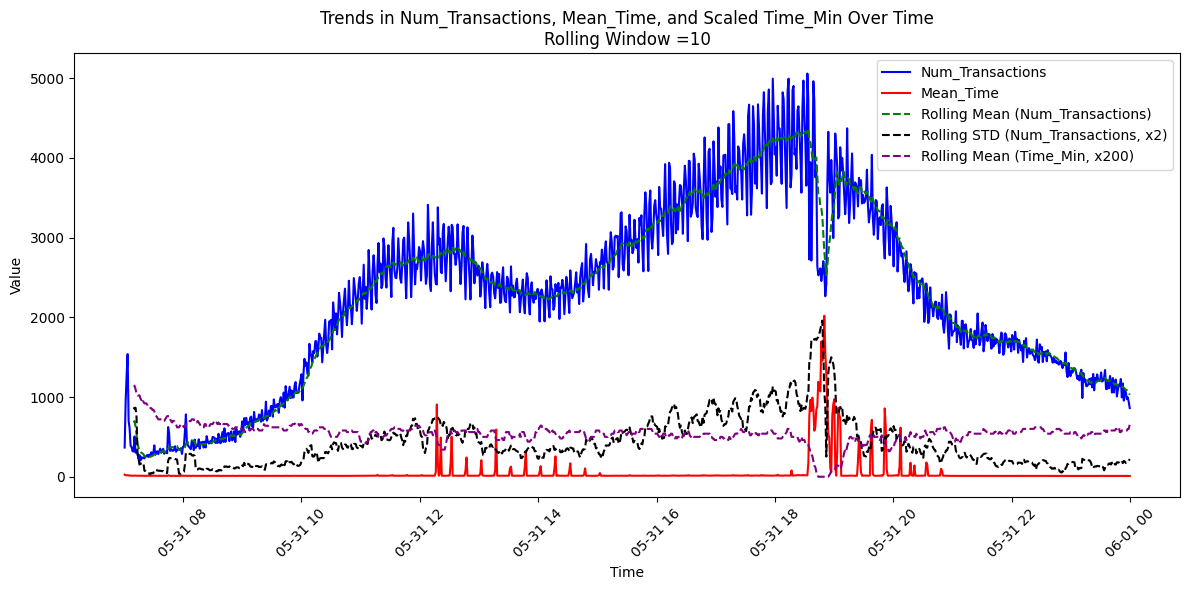

In [ ]:
# Trends in Num_Transactions with its Rolling STD, Mean_Time and Scaled Time_Min

plt.figure(figsize=(12, 6))

# Convert 'Timestamp' to datetime objects
raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
raw_df = raw_df.dropna(subset=['Timestamp'])  # remove rows with invalid date values

# Plotting the time series
plt.plot(raw_df['Timestamp'], raw_df['Num_Transactions'], label='Num_Transactions', color='blue')
plt.plot(raw_df['Timestamp'], raw_df['Mean_Time'], label='Mean_Time', color='red')


# Rolling mean
window = 10
plt.plot(raw_df['Timestamp'], raw_df['Num_Transactions'].rolling(window=window).mean(), label='Rolling Mean (Num_Transactions)', color='green', linestyle='--')
plt.plot(raw_df['Timestamp'], raw_df['Num_Transactions'].rolling(window=window).std()*2, label='Rolling STD (Num_Transactions, x2)', color='black', linestyle='--')

#plt.plot(raw_df['Timestamp'], raw_df['Mean_Time'].rolling(window=window).mean(), label='Rolling Mean (Mean_Time)', color='orange', linestyle='--')
plt.plot(raw_df['Timestamp'], raw_df['Time_Min'].rolling(window=window).mean() * 200, label='Rolling Mean (Time_Min, x200)', color='purple', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Trends in Num_Transactions, Mean_Time, and Scaled Time_Min Over Time\nRolling Window ={window}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"./images/04-trends.png")
plt.show()

This time series plot provides a view of the trends in three key variables: **`Num_Transactions`**, **`Mean_Time`**, and **`Time_Min`**, with smoothing techniques applied through a rolling window of size 10. The variables are visualized with different scaling to allow for meaningful comparisons on the same axis.

The **blue line represents `Num_Transactions`**, showing the number of transactions recorded at each time interval. A clear upward trend is visible throughout the early part of the day, peaking around 18:00. After this peak, the number of transactions steadily declines. This suggests a daily pattern that we have to take care while we are generating new data. 

The **green dashed line**, which is the rolling mean of `Num_Transactions`, smooths the short-term fluctuations and confirms the overall pattern of rising and then falling transaction volume. In addition, the **black dashed line** shows the rolling standard deviation (multiplied by 2 for visibility), which increases alongside transaction volume. This indicates that periods of high activity also exhibit greater variability.

The **red line corresponds to `Mean_Time`**, reflecting the average processing time per interval. This variable remains low and stable for much of the day but displays sudden sharp spikes, particularly after 17:30. These peaks are brief but pronounced, suggesting isolated intervals where performance issues arose. This could be due to system overload, or anomalies.

To add further context, **`Time_Min`** is included as the **magenta dashed line**, scaled by a factor of 200 to match the vertical range of the other metrics. Although this variable is relatively flat throughout the day, there is a slight downward trend in the morning followed by mild fluctuations. This stability contrasts with the more volatile behavior of `Mean_Time` and `Num_Transactions`, implying that while individual transactions may occasionally process instantly (Time\_Min), the average system performance is more sensitive to load.


## 1.4 Summary:


The analysis helped us understand the nature of the dataset and the potenial anomalies in a transaction dataset. Based on the analysis, potential anomalies might be outliers in `Time_Max` (unusually long transaction processing times),`Time_Min` (when it decreases to 0 and it happens when number of transactions are unusually high) and `Num_Retries` (periods of high system instability). Trends in `Num_Transactions` and `Mean_Time` should be examined for spikes, dips, or consistent patterns that might indicate bottlenecks or periods of low activity.

Insights for Next Steps:

* **Investigating Outliers:** In next steps we will dive into the instances flagged as potential outliers in `Time_Max` and `Num_Retries` to determine their root causes. Are these genuine anomalies, or are they due to expected system behavior under specific conditions?
We will apply anomaly detection algorithm to the dataset to identify statistically significant deviations from normal behavior.


In [7]:
# Configuration for variations - set these to True/False to enable/disable
VARIATION_CONFIG = {
    "increased_noise": True,  # #1: Increase noise levels
    "add_outliers": False,  # #3: Add occasional outliers
    "vary_distributions": True,  # #4: Vary sampling distributions
    "add_time_trends": False,  # #5: Add time-based trends
    "vary_sequences": True,  # #6: Use different sequence patterns
    "modify_correlations": True,  # #7: Modify correlation structure
}
increased_noise_VARIATION = 0.10  # Increase noise levels by this factor
increased_noise_Factor = 1.08  # Increase noise levels by this factor

outlier_col = np.random.choice(["Num_Transactions", "Time_Max"])
outlier_factor = np.random.choice(
    [1.07, 1.06, 1.05, 1.02, 1, 0.97, 0.96, 0.95, 0.93]
)  # Either much higher or lower


# Function to create visualizations of patterns
def create_pattern_visualizations(df):
    # Convert timestamp to datetime
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(7, 2, figsize=(20, 24))

    # List of columns to analyze
    columns = [
        "Interval_s",
        "Num_Transactions",
        "Time_Min",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ]

    # Create time series plots and histograms
    for i, col in enumerate(columns):
        # Time series plot
        axes[i, 0].plot(df["Timestamp"], df[col])
        axes[i, 0].set_title(f"{col} Time Series")
        axes[i, 0].set_xlabel("Time")
        axes[i, 0].set_ylabel(col)
        axes[i, 0].tick_params(axis="x", rotation=45)

        # Histogram
        axes[i, 1].hist(df[col], bins=30)
        axes[i, 1].set_title(f"{col} Distribution")
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_ylabel("Frequency")

    plt.tight_layout()

    # Save the figure to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)

    # Convert the image to base64 string
    img_str = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)

    return img_str


# Comprehensive analysis of your existing data
def analyze_data(df):
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Sort by timestamp
    df_copy = df_copy.sort_values("Timestamp")

    # Basic statistics
    stats = {}
    for col in [
        "Interval_s",
        "Num_Transactions",
        "Time_Min",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ]:
        stats[col] = {
            "min": float(df_copy[col].min()),
            "max": float(df_copy[col].max()),
            "mean": float(df_copy[col].mean()),
            "median": float(df_copy[col].median()),
            "std": float(df_copy[col].std()),
            "q1": float(df_copy[col].quantile(0.25)),
            "q3": float(df_copy[col].quantile(0.75)),
            "skew": float(scipy_stats.skew(df_copy[col])),
            "kurtosis": float(scipy_stats.kurtosis(df_copy[col])),
        }

    return {
        "basic_stats": stats,
    }


# Perform the analysis
analysis = analyze_data(raw_df)


# Function to generate synthetic data using statistical models
def generate_data_for_day(num_records=1018, trend_factor=1.0):
    # Get basic stats for reference
    stats = analysis["basic_stats"]

    # Create a copy of the original data for sampling
    df_copy = raw_df.copy()
    df_copy["Timestamp"] = pd.to_datetime(df_copy["Timestamp"])
    df_copy = df_copy.sort_values("Timestamp")

    # Extract sequences from original data to maintain patterns
    sequence_length = min(24, len(df_copy) // 10)
    sequences = []
    for i in range(
        0, len(df_copy) - sequence_length, sequence_length // 2
    ):  # Overlapping sequences
        seq = df_copy.iloc[i : i + sequence_length].copy()
        sequences.append(seq)

    # Generate data by sampling and modifying sequences
    remaining = num_records
    result_data = []

    while remaining > 0:
        # Randomly select a sequence
        seq = sequences[np.random.randint(0, len(sequences))].copy()
        # Adjust length if needed
        if len(seq) > remaining:
            seq = seq.iloc[:remaining]

        # VARIATION #6: Vary sequence patterns
        if (
            VARIATION_CONFIG["vary_sequences"] and np.random.random() < 0.2
        ):  # 20% of the time
            if np.random.random() < 0.5:
                # Reverse the sequence
                seq = seq.iloc[::-1].reset_index(drop=True)
            else:
                # Shuffle the sequence (but maintain internal correlations)
                idx = np.random.permutation(len(seq))
                seq = seq.iloc[idx].reset_index(drop=True)

        # Modify the sequence to avoid exact duplication
        for col in [
            "Interval_s",
            "Num_Transactions",
            "Time_Min",
            "Time_Max",
            "Mean_Time",
            "Num_Retries",
            "Num_Wrong_Transactions",
        ]:
            # VARIATION #1: Increased noise levels
            noise_level = stats[col]["std"] * (
                increased_noise_VARIATION
                if VARIATION_CONFIG["increased_noise"]
                else 0.1
            )

            if col in ["Num_Transactions", "Num_Retries", "Num_Wrong_Transactions"]:
                # For integer columns
                noise = np.random.randint(-1, 2, size=len(seq))  # -1, 0, or 1
                seq[col] = np.clip(
                    seq[col] + noise, stats[col]["min"], stats[col]["max"]
                ).astype(int)
            else:
                # For float columns
                noise = np.random.normal(0, noise_level, size=len(seq))
                seq[col] = np.clip(
                    seq[col] + noise, stats[col]["min"], stats[col]["max"]
                ).round(2)

            # VARIATION #5: Add time-based trends
            if VARIATION_CONFIG["add_time_trends"]:
                # Apply trend factor
                seq[col] = seq[col] * trend_factor

        # VARIATION #3: Add occasional outliers
        if VARIATION_CONFIG["add_outliers"]:
            for i in range(len(seq)):
                if np.random.random() < 0.01:  # 1% chance of outlier
                    seq.loc[seq.index[i], outlier_col] = (
                        seq.loc[seq.index[i], outlier_col] * outlier_factor
                    )

                    # Ensure constraints are still met
                    if outlier_col == "Time_Max":
                        seq.loc[seq.index[i], "Time_Max"] = max(
                            seq.loc[seq.index[i], "Time_Max"],
                            seq.loc[seq.index[i], "Time_Min"] * 1.05,
                        )
                        seq.loc[seq.index[i], "Mean_Time"] = (
                            seq.loc[seq.index[i], "Time_Min"]
                            + seq.loc[seq.index[i], "Time_Max"]
                        ) / 2

        # VARIATION #7: Modify correlation structure
        if VARIATION_CONFIG["modify_correlations"]:
            for i in range(len(seq)):
                if np.random.random() < 0.3:  # 30% of the time
                    # Find two correlated columns
                    corr_cols = ["Time_Min", "Time_Max"]
                    # Get current values
                    val1, val2 = (
                        seq.loc[seq.index[i], corr_cols[0]],
                        seq.loc[seq.index[i], corr_cols[1]],
                    )
                    # Add independent noise to slightly decorrelate
                    seq.loc[seq.index[i], corr_cols[0]] = val1 * (
                        1 + np.random.normal(0, 0.05)
                    )
                    seq.loc[seq.index[i], corr_cols[1]] = val2 * (
                        1 + np.random.normal(0, 0.05)
                    )
                    # Ensure constraints
                    if (
                        corr_cols == ["Time_Min", "Time_Max"]
                        and seq.loc[seq.index[i], "Time_Max"]
                        <= seq.loc[seq.index[i], "Time_Min"]
                    ):
                        seq.loc[seq.index[i], "Time_Max"] = (
                            seq.loc[seq.index[i], "Time_Min"] * 1.1
                        )

        # Ensure constraints
        seq["Time_Max"] = np.maximum(seq["Time_Min"] * 1.05, seq["Time_Max"])
        seq["Mean_Time"] = (seq["Time_Min"] + seq["Time_Max"]) / 2

        # Add to result
        result_data.append(seq)
        remaining -= len(seq)

    # Combine all generated data
    if result_data:
        combined_df = pd.concat(result_data, ignore_index=True)

        # Sort by timestamp
        combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"])
        combined_df = combined_df.sort_values("Timestamp").reset_index(drop=True)

        # Ensure we have exactly num_records
        if len(combined_df) > num_records:
            combined_df = combined_df.iloc[:num_records]

        return combined_df
    else:
        return None


# Generate data for multiple days
def generate_multiple_days(num_days, records_per_day=1018):
    all_data = []

    # VARIATION #5: Initialize trend factor
    trend_factor = 1.0
    trend_direction = np.random.choice([-1, 1])  # Random direction

    for i in range(num_days):
        # VARIATION #5: Update trend factor if enabled
        if VARIATION_CONFIG["add_time_trends"]:
            trend_factor += trend_direction * 0.02  # 2% change per day
            # Reverse direction if trend gets too extreme
            if trend_factor > 1.2 or trend_factor < 0.8:
                trend_direction *= -1
            print(f"Using trend factor: {trend_factor:.2f}")

        day_data = generate_data_for_day(records_per_day, trend_factor)
        if day_data is not None:
            all_data.append(day_data)

    return pd.concat(all_data, ignore_index=True)


# Example usage
num_days_to_generate = 9  # Variable number of days


file_path = "./data/generated_transaction_data.csv"
gen_data = None
if os.path.exists(file_path):
    gen_data = pd.read_csv(file_path, parse_dates=True)
    gen_data["Timestamp"] = pd.to_datetime(
        gen_data["Timestamp"], dayfirst=False, errors="coerce"
    )
else:
    gen_data = generate_multiple_days(num_days_to_generate, records_per_day)
    time_stamps = []
    for i in range(num_days_to_generate):
        time_stamps.append(raw_df["Timestamp"] + timedelta(days=i + 1))
    time_stamps = np.reshape(time_stamps, (num_days_to_generate * records_per_day))

    gen_data["Timestamp"] = time_stamps
    gen_data["Code_ID"] = 8
    gen_data["Interval_s"] = 60
    gen_data["Num_Transactions"] = gen_data["Num_Transactions"].astype(int)
    gen_data["Num_Retries"] = gen_data["Num_Retries"].astype(int)
    gen_data["Num_Wrong_Transactions"] = gen_data["Num_Wrong_Transactions"].astype(int)
    gen_data["Time_Min"] = gen_data["Time_Min"].astype(int)
    gen_data["Time_Max"] = gen_data["Time_Max"].astype(int)
    gen_data["Timestamp"] = pd.to_datetime(
        gen_data["Timestamp"], dayfirst=True, errors="coerce"
    )

    gen_data.to_csv(file_path, index=False)
    print(
        f"Successfully generated {len(gen_data)} records for {num_days_to_generate} days"
    )
    print(gen_data.head())

    # Validate the generated data
    print("\nOriginal data statistics:")
    for col in [
        "Interval_s",
        "Num_Transactions",
        "Time_Min",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ]:
        print(
            f"{col}: mean={raw_df[col].mean():.2f}, std={raw_df[col].std():.2f}, min={raw_df[col].min():.2f}, max={raw_df[col].max():.2f}"
        )

    print("\nGenerated data statistics:")
    for col in [
        "Interval_s",
        "Num_Transactions",
        "Time_Min",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ]:
        print(
            f"{col}: mean={gen_data[col].mean():.2f}, std={gen_data[col].std():.2f}, min={gen_data[col].min():.2f}, max={gen_data[col].max():.2f}"
        )


/tmp/ipykernel_8481/3199141783.py:94: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skew": float(scipy_stats.skew(df_copy[col])),
/tmp/ipykernel_8481/3199141783.py:95: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "kurtosis": float(scipy_stats.kurtosis(df_copy[col])),


In [8]:
gen_data

Code_ID           Timestamp  Interval_s  Num_Transactions  Time_Min  \
0           8 2024-06-01 07:01:11          60               248         3   
1           8 2024-06-01 07:02:11          60               277         4   
2           8 2024-06-01 07:03:11          60               260         4   
3           8 2024-06-01 07:04:11          60               307         3   
4           8 2024-06-01 07:05:11          60               275         3   
...       ...                 ...         ...               ...       ...   
9157        8 2024-06-09 23:55:23          60              1218         3   
9158        8 2024-06-09 23:56:23          60              1007         2   
9159        8 2024-06-09 23:57:23          60              1088         3   
9160        8 2024-06-09 23:58:23          60              1158         3   
9161        8 2024-06-09 23:59:23          60              1144         0   

      Time_Max   Mean_Time  Num_Retries  Num_Wrong_Transactions  
0           28   15.970000            0                      90  
1          282  143.390000            0                      90  
2           28   16.065000            1                      89  
3          131   67.955000            0                      90  
4           28   16.354894            0                      91  
...        ...         ...          ...                     ...  
9157        28   15.550000            1                     184  
9158      1334  668.540000            0                     123  
9159      1182  592.680000            1                     190  
9160       567  285.525467            1                     162  
9161        27   14.280588            0                     136  

[9162 rows x 9 columns]

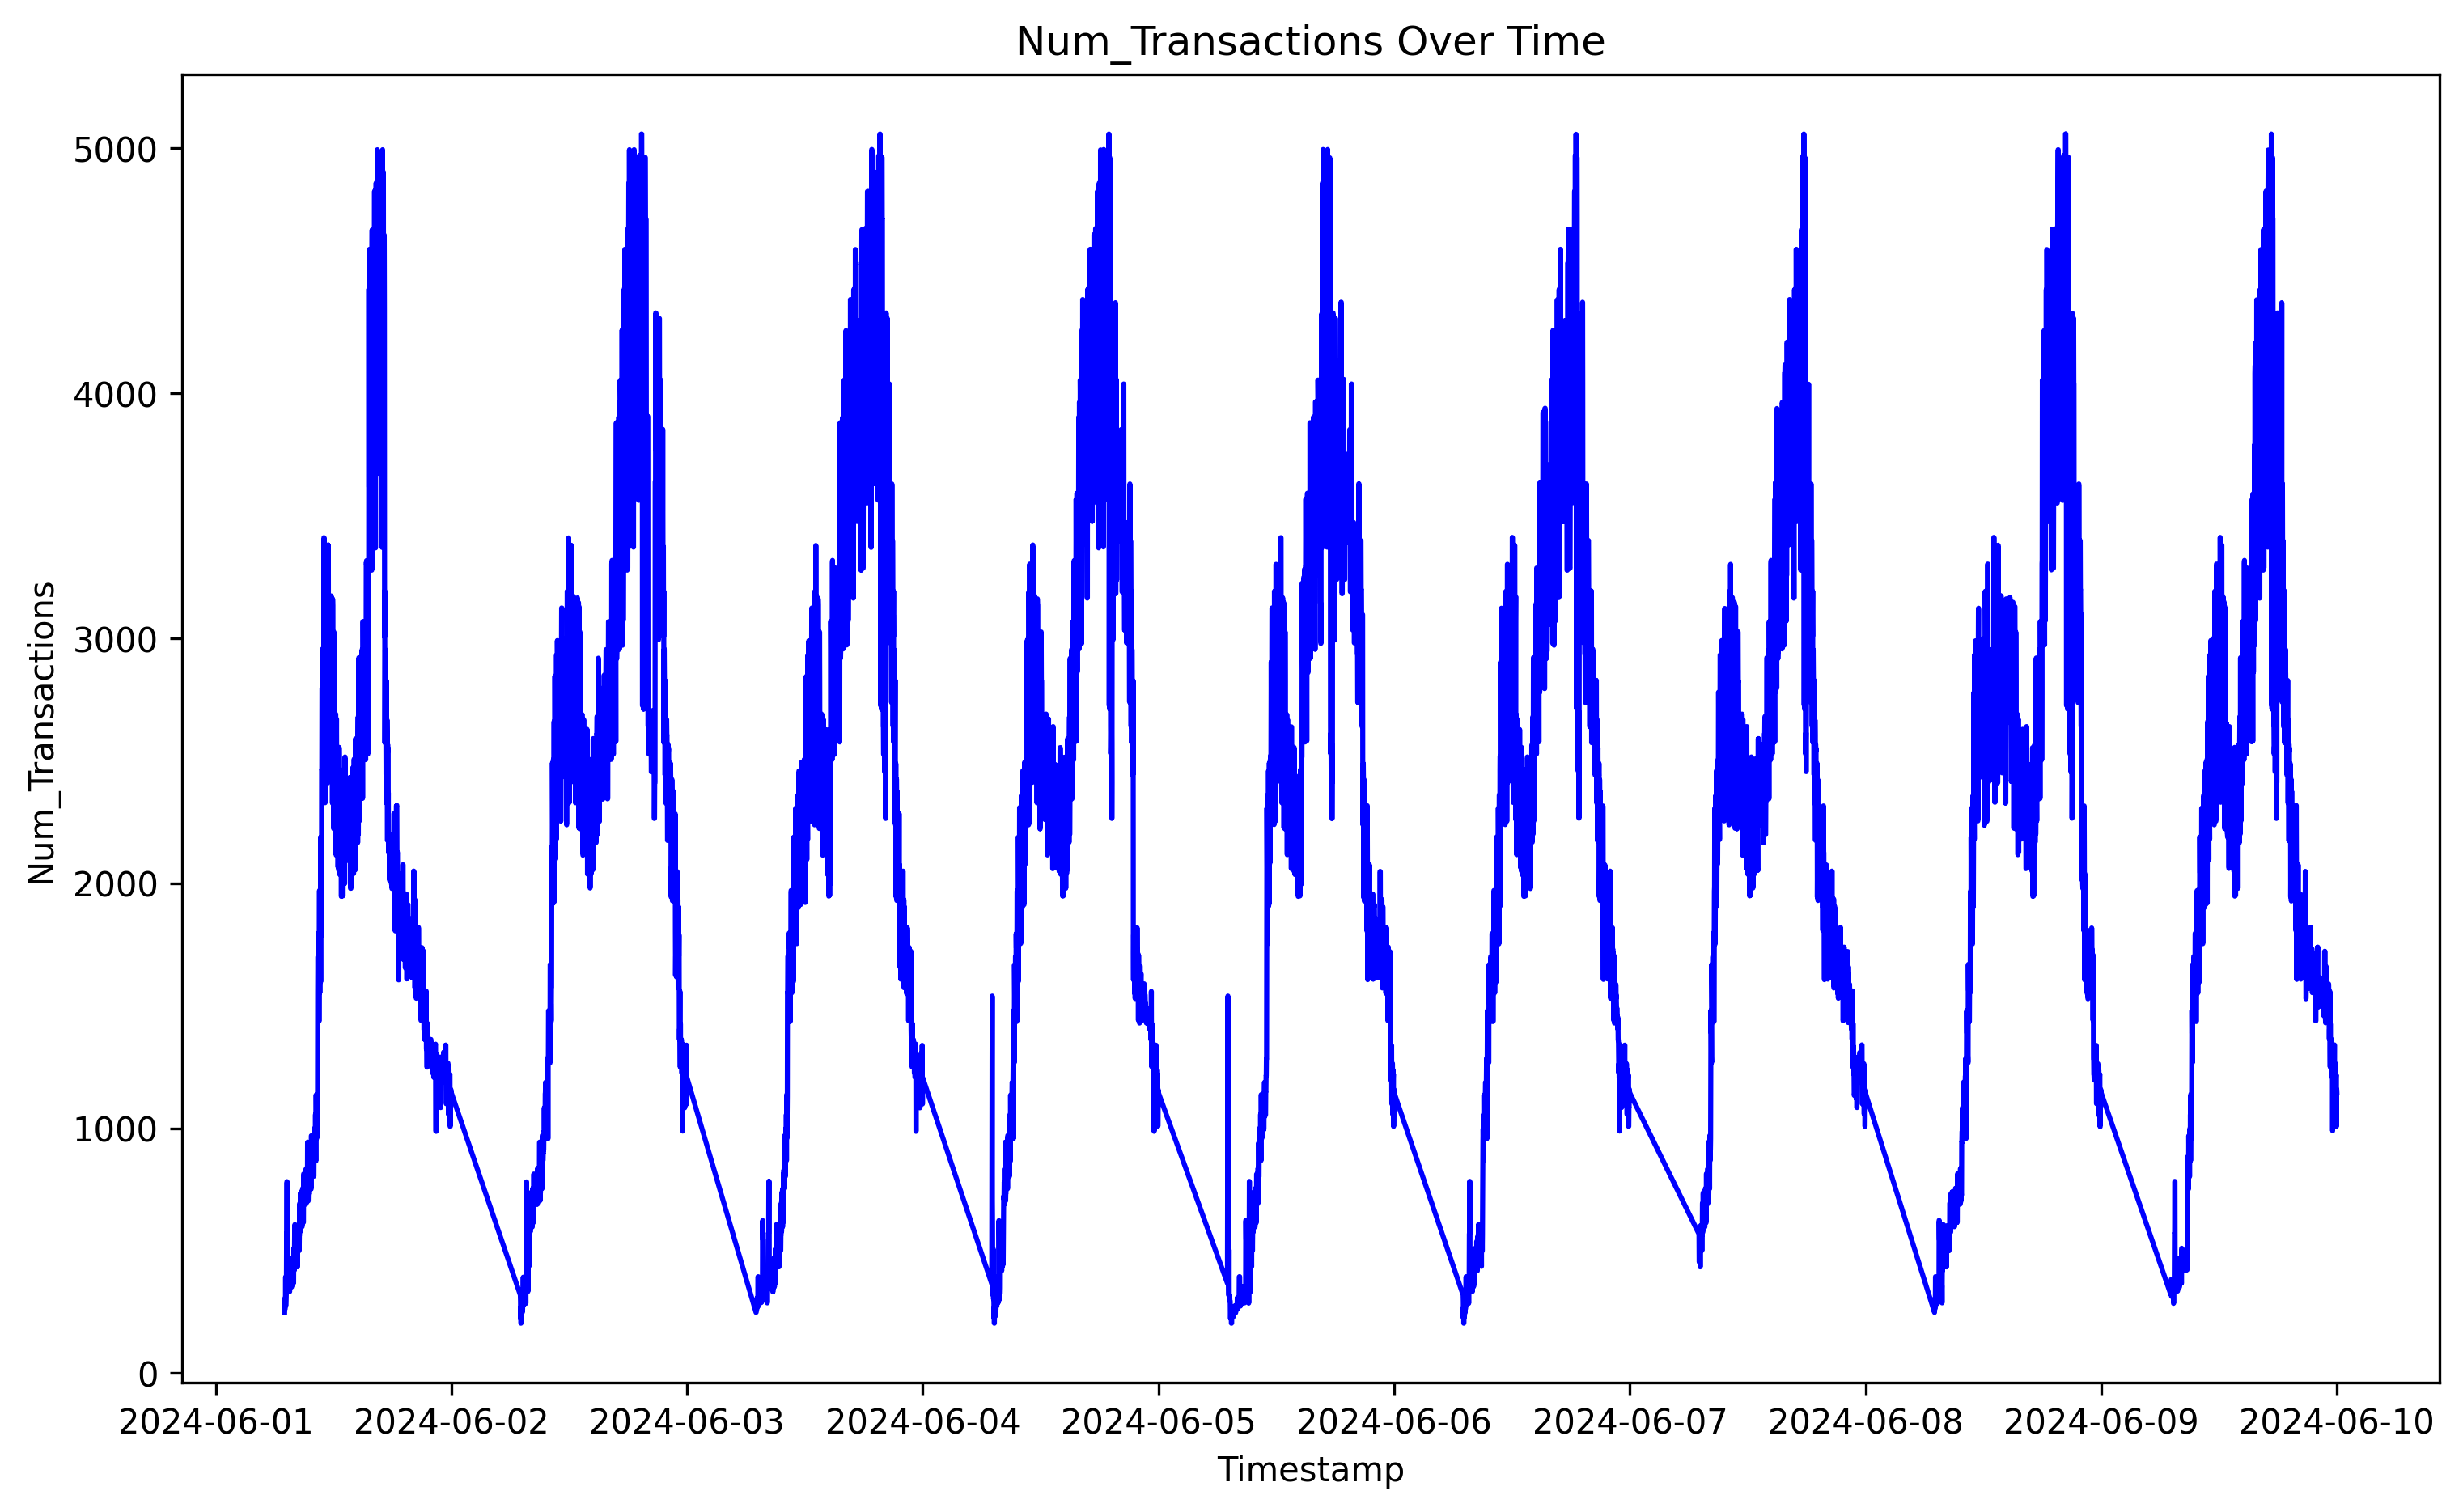

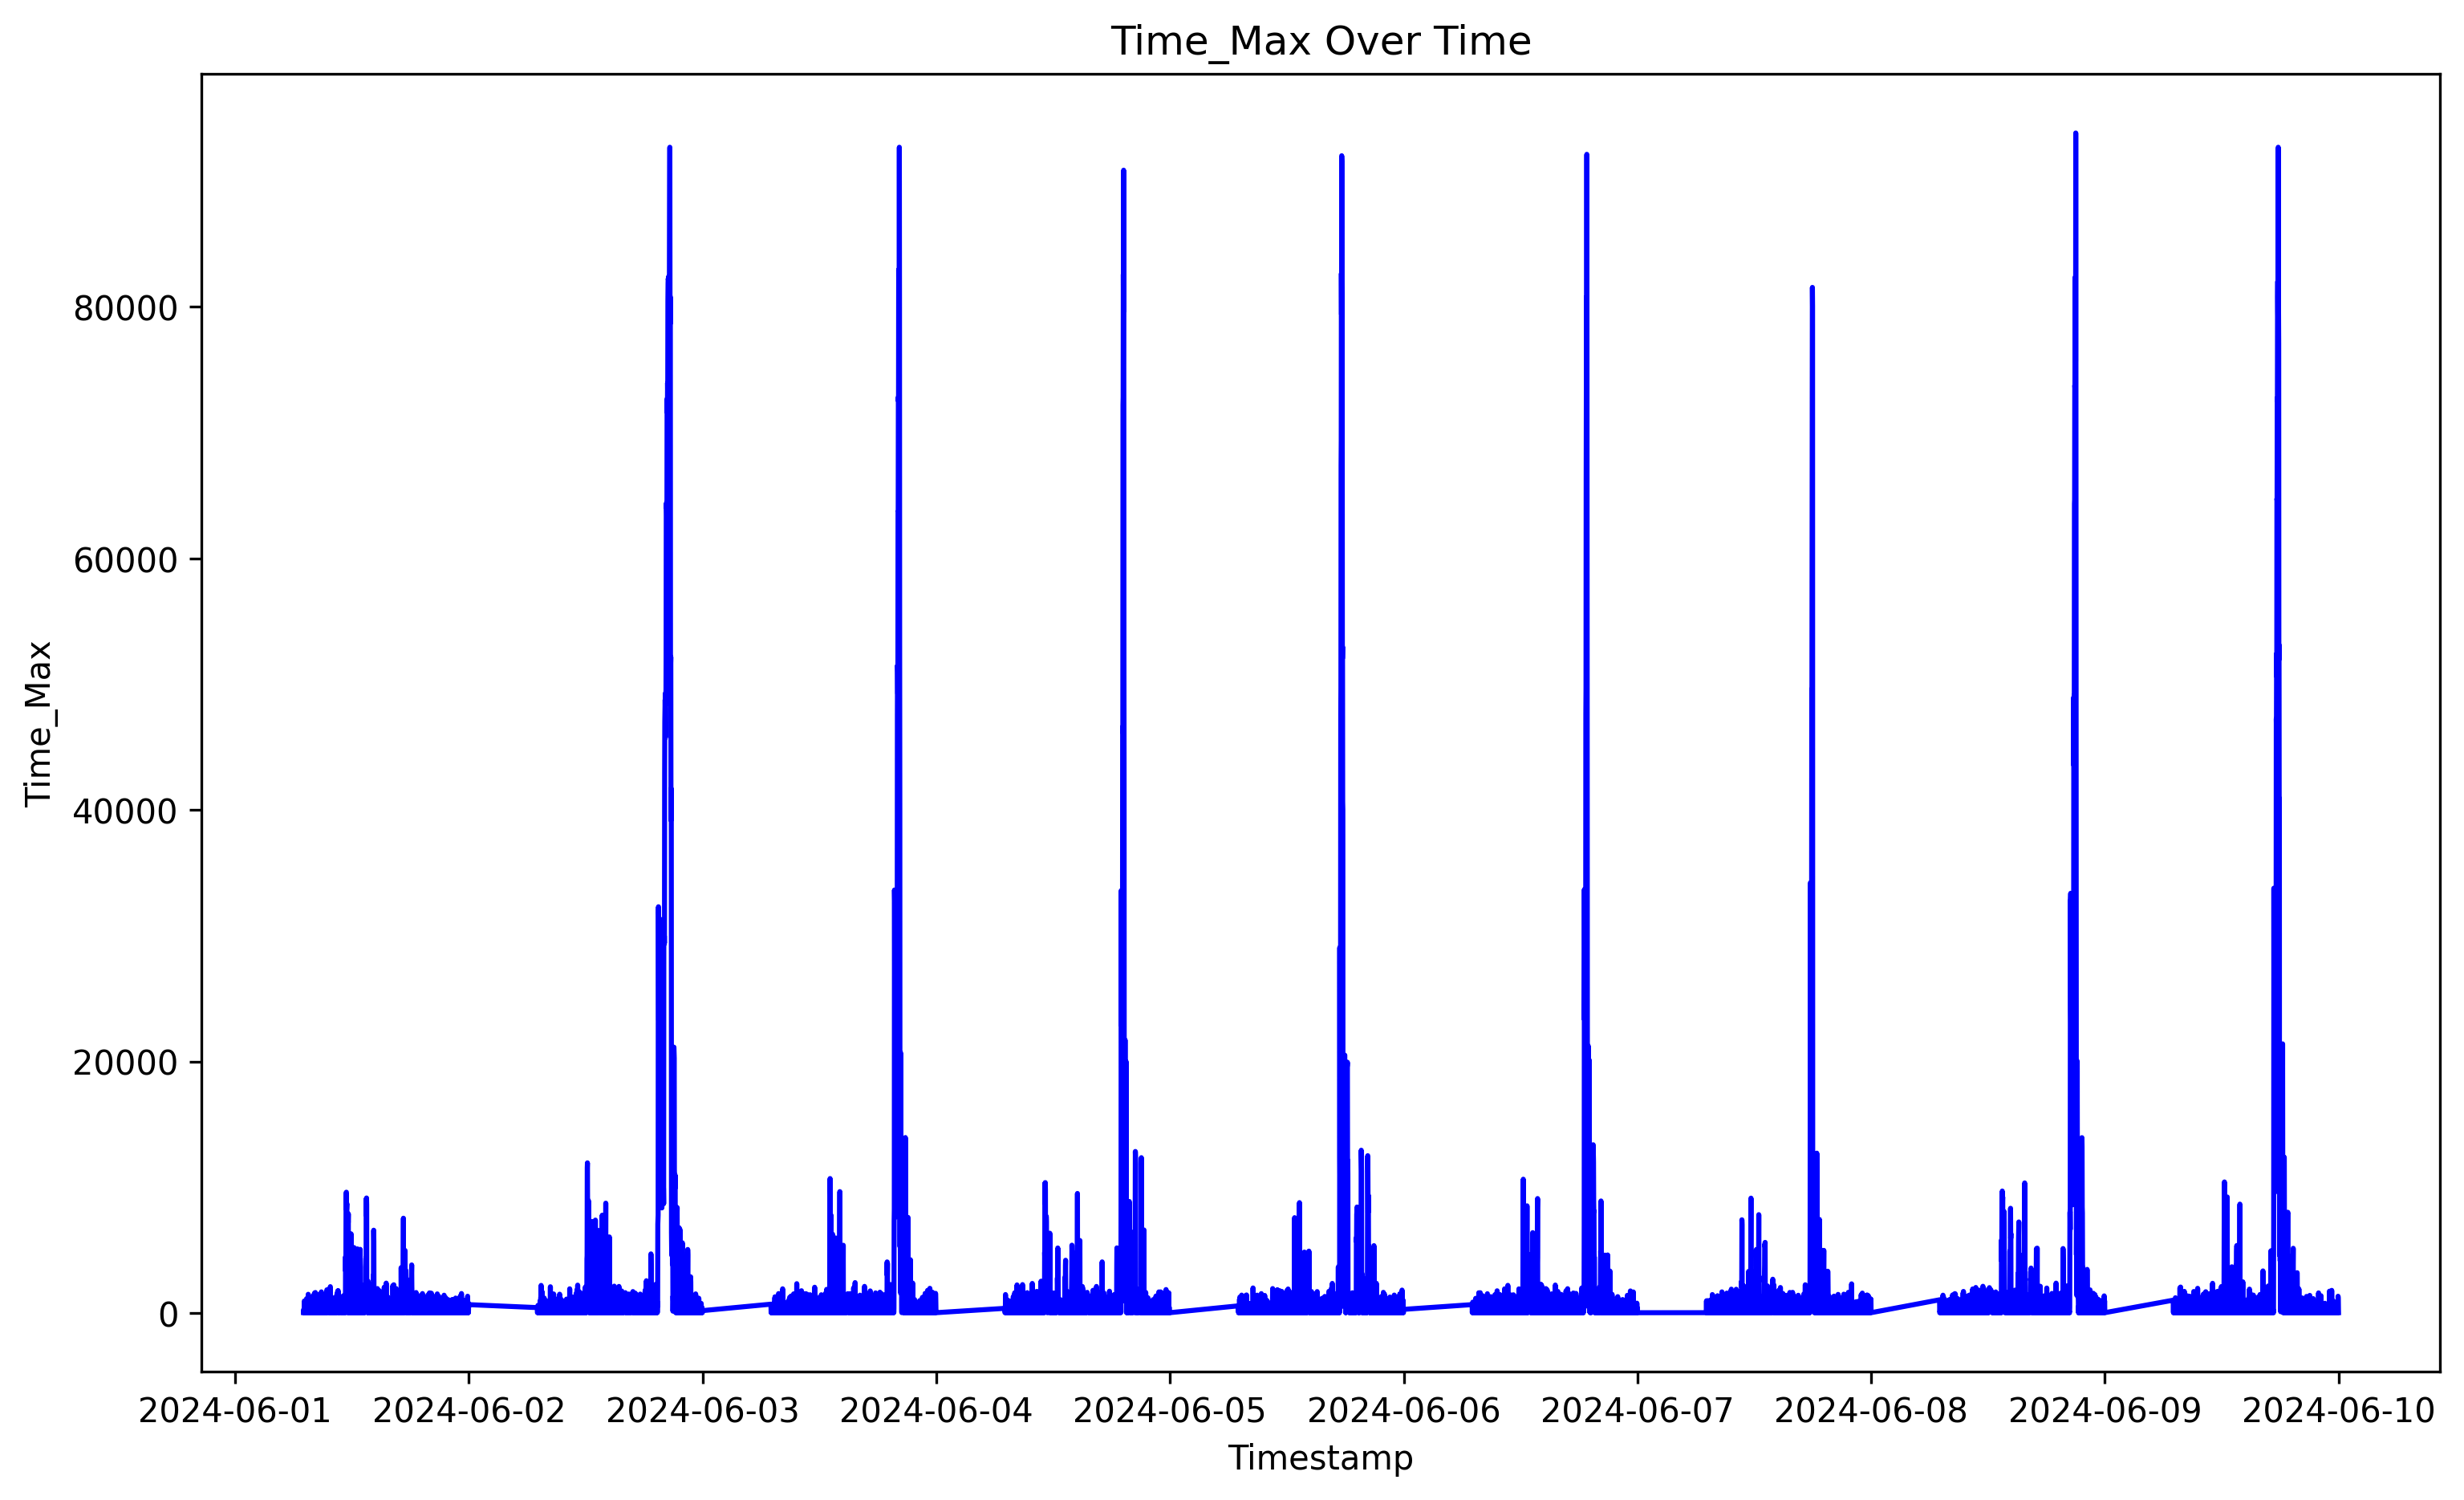

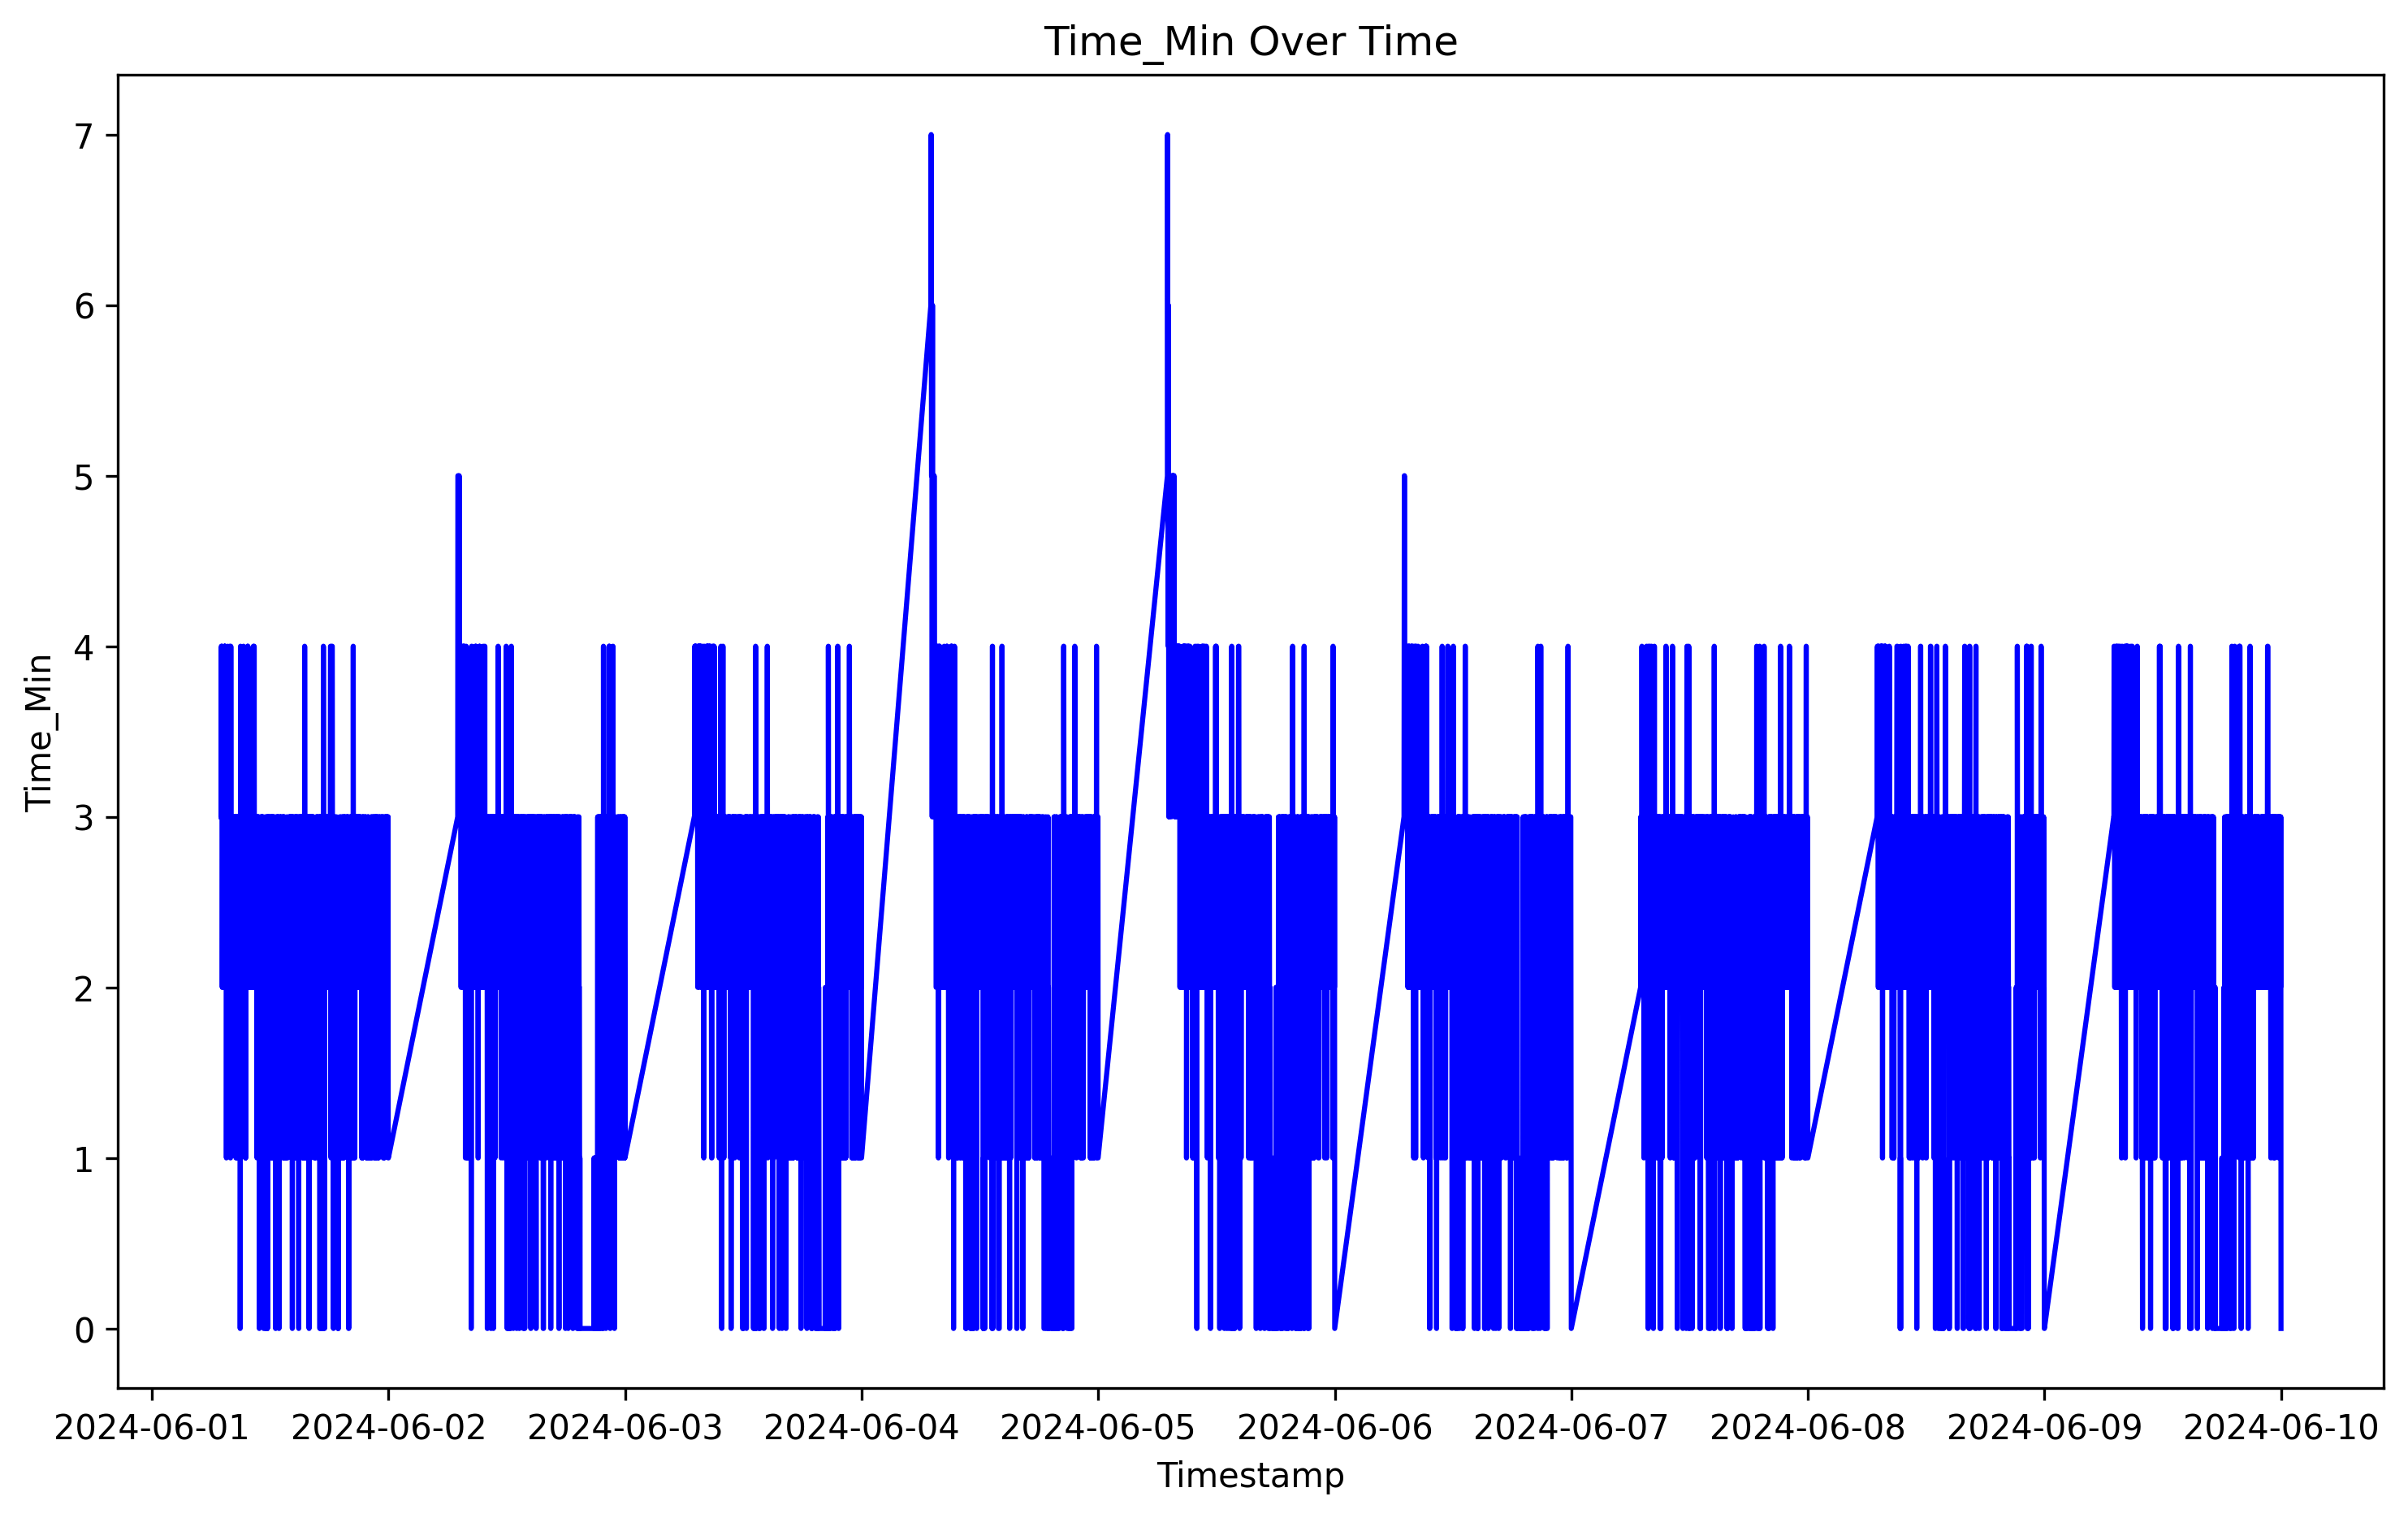

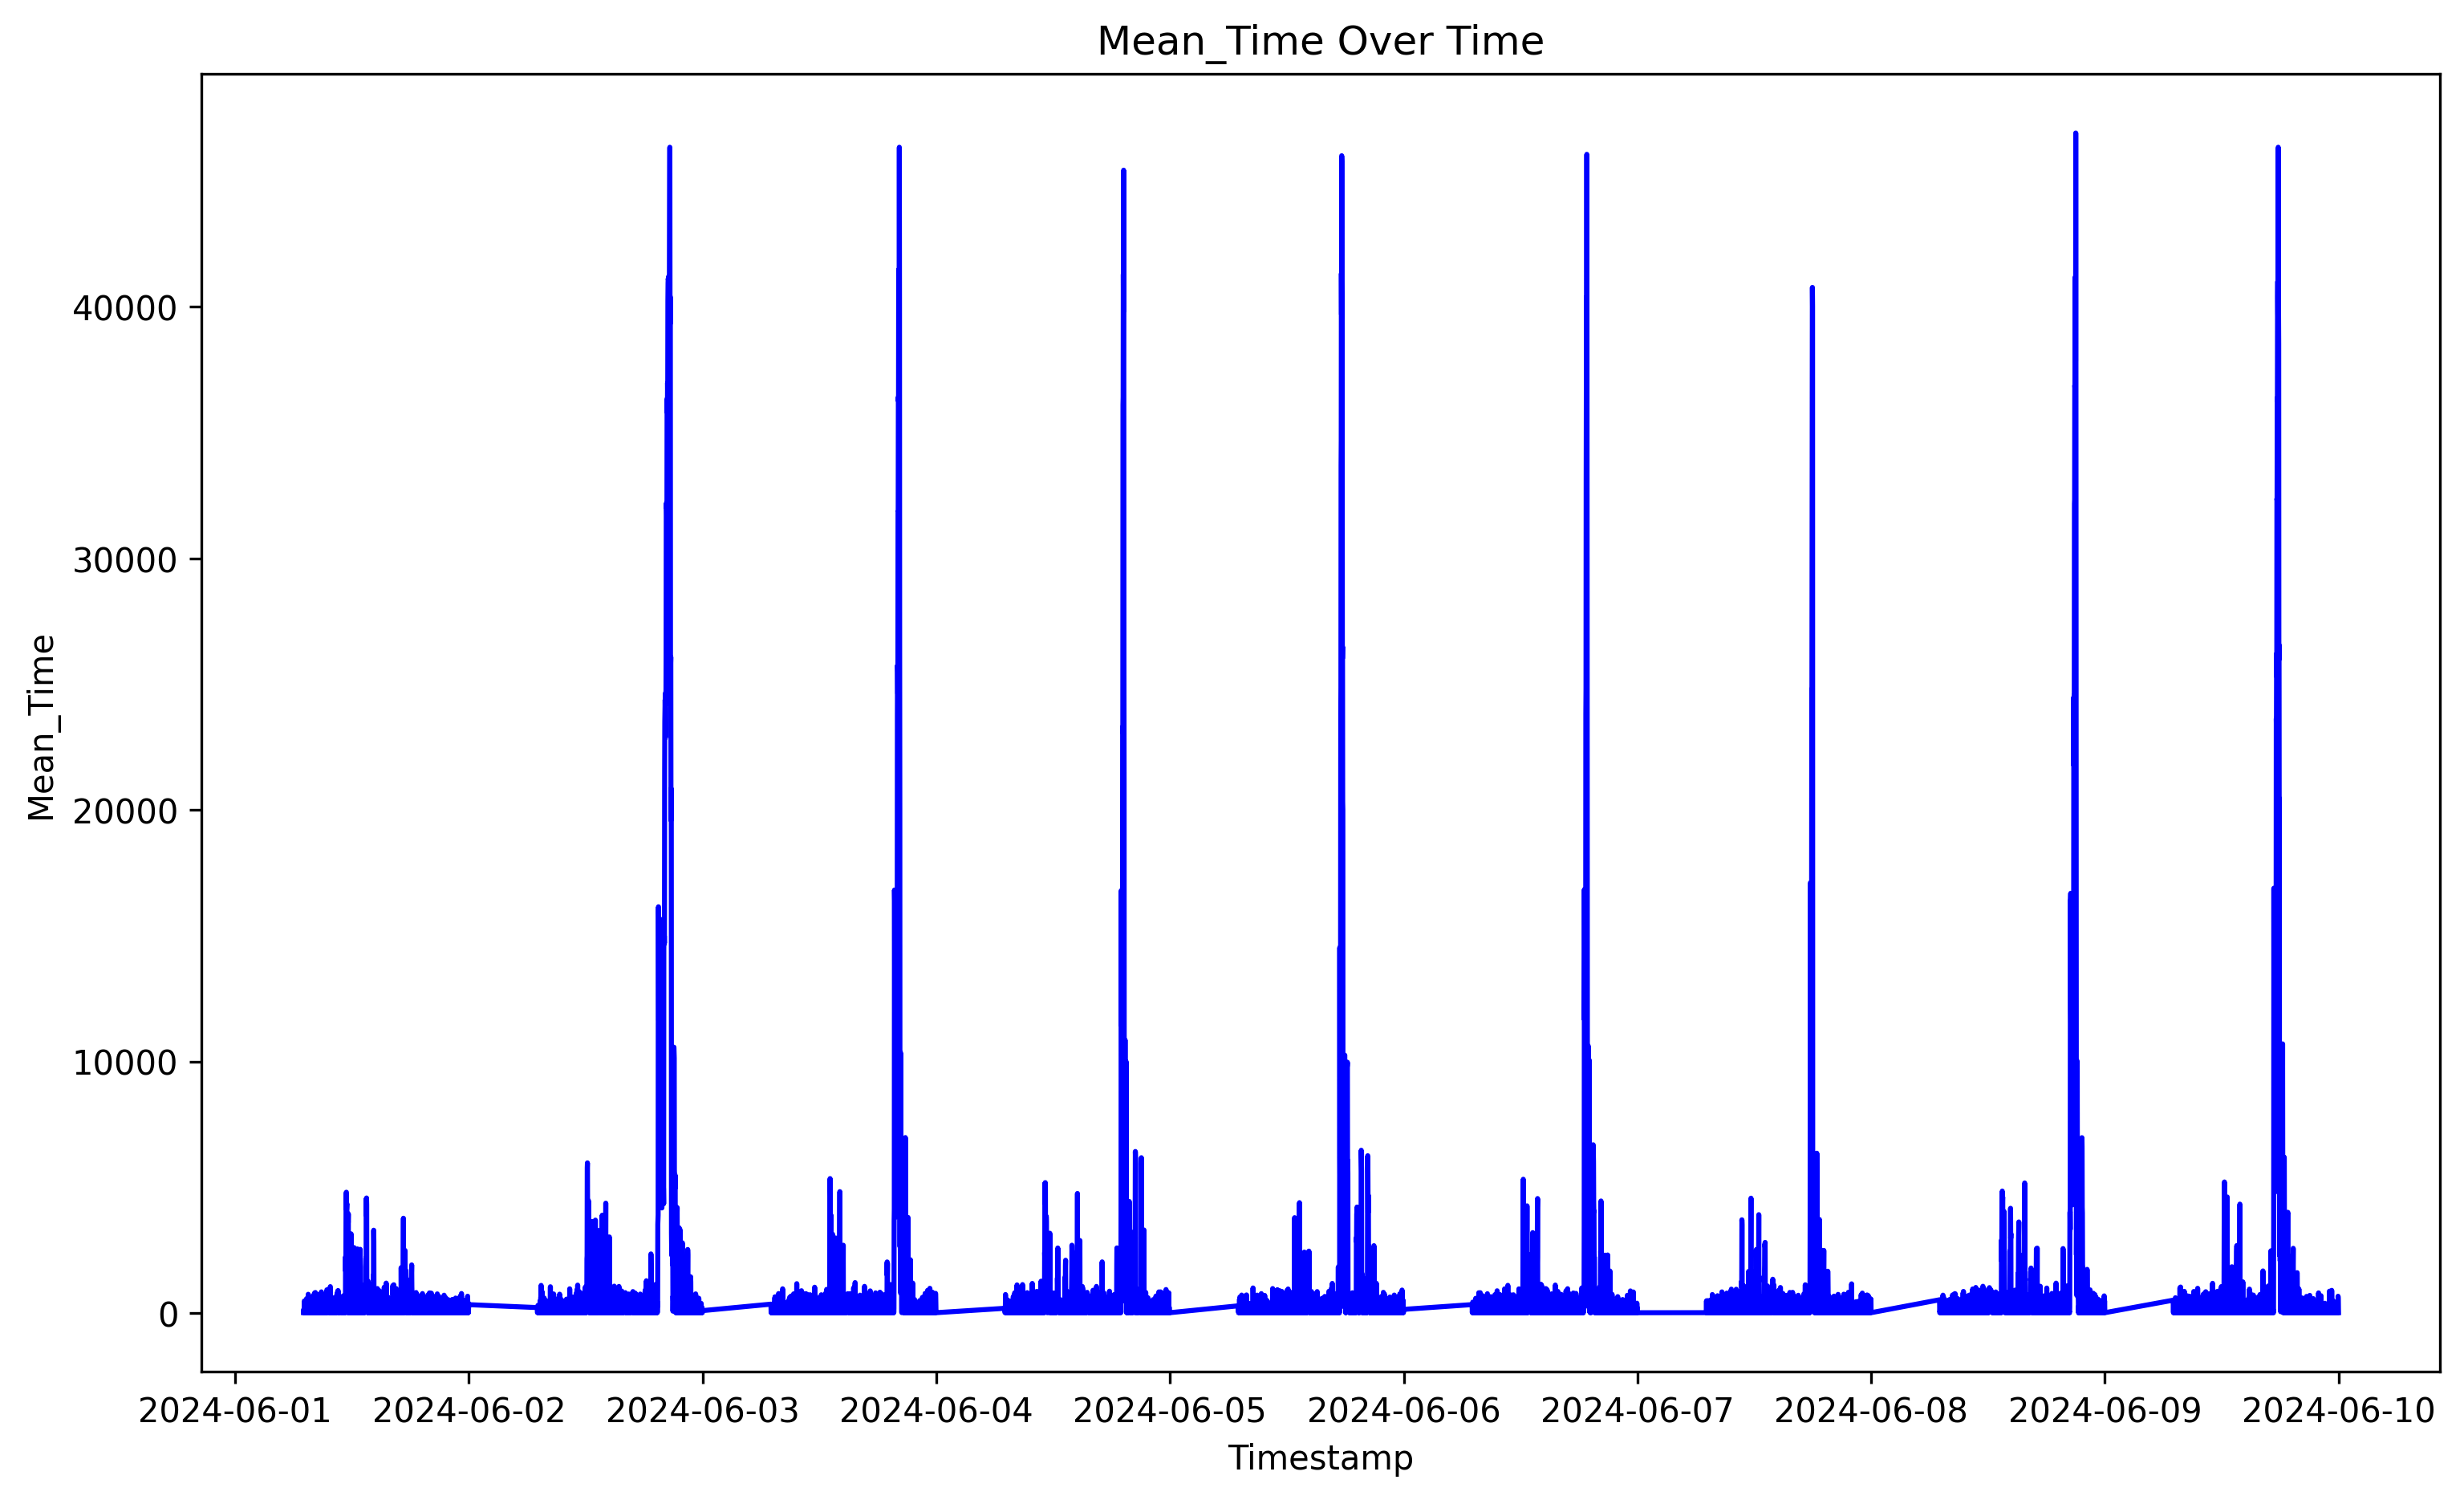

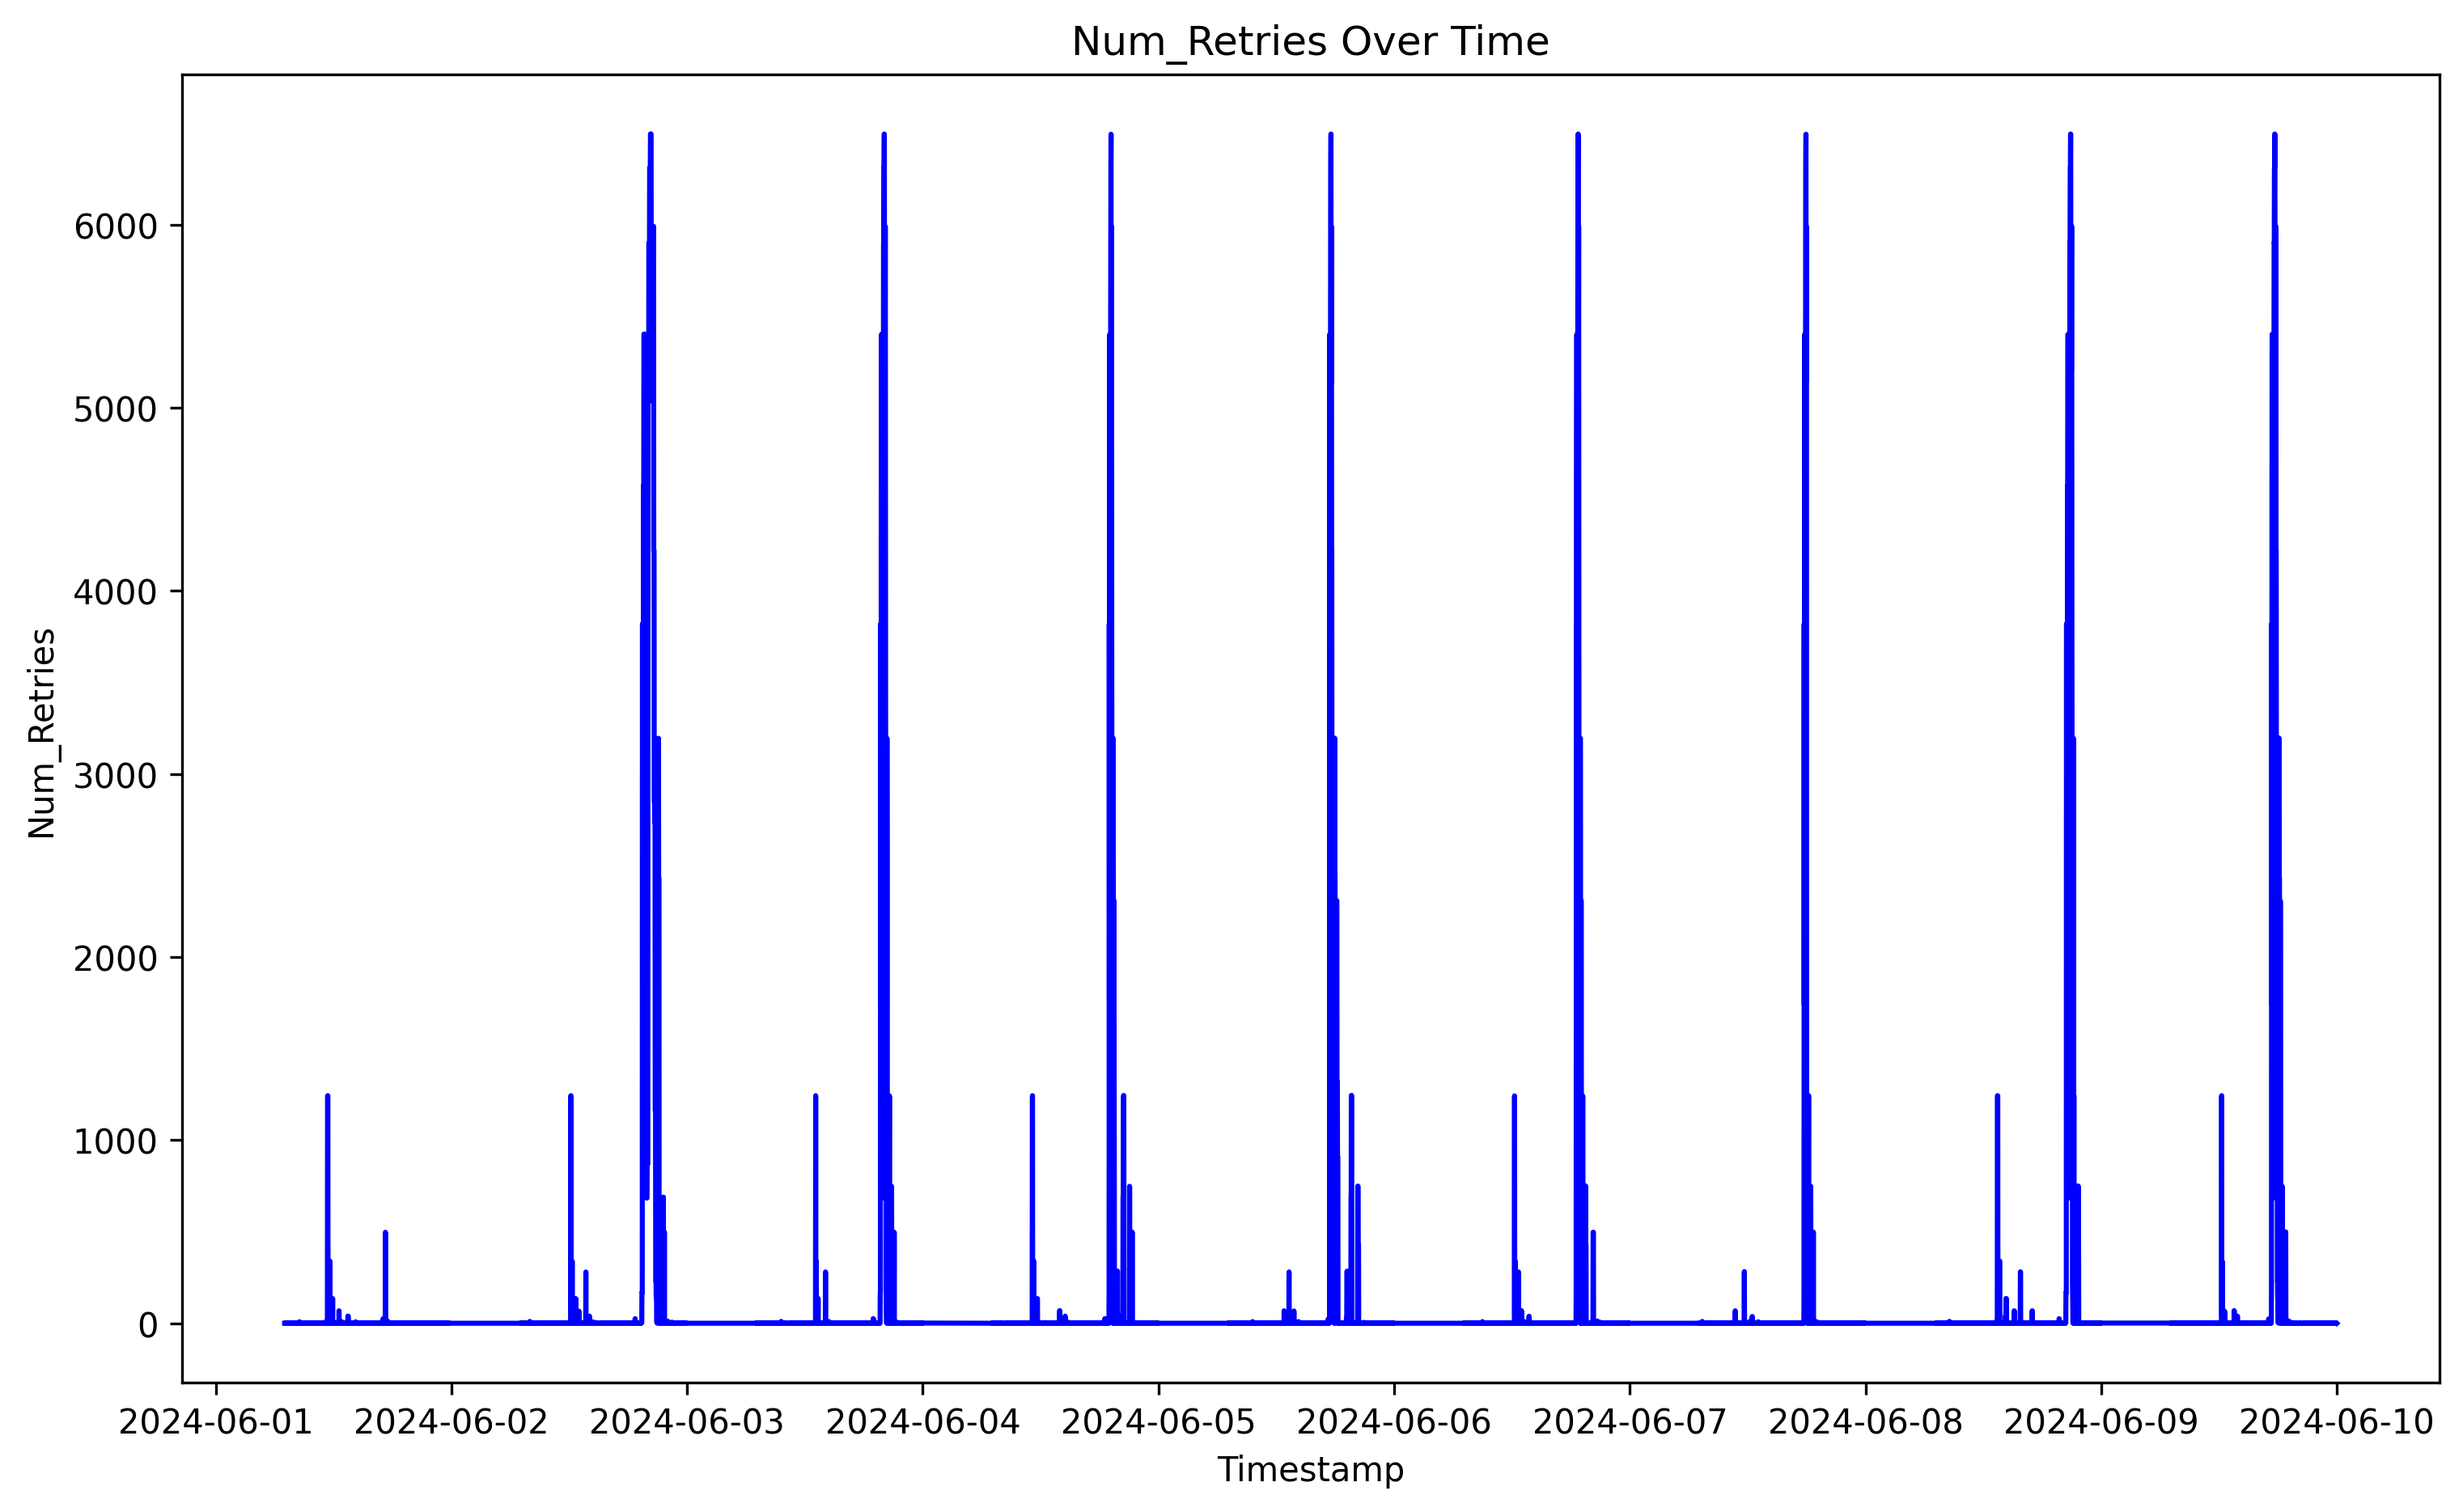

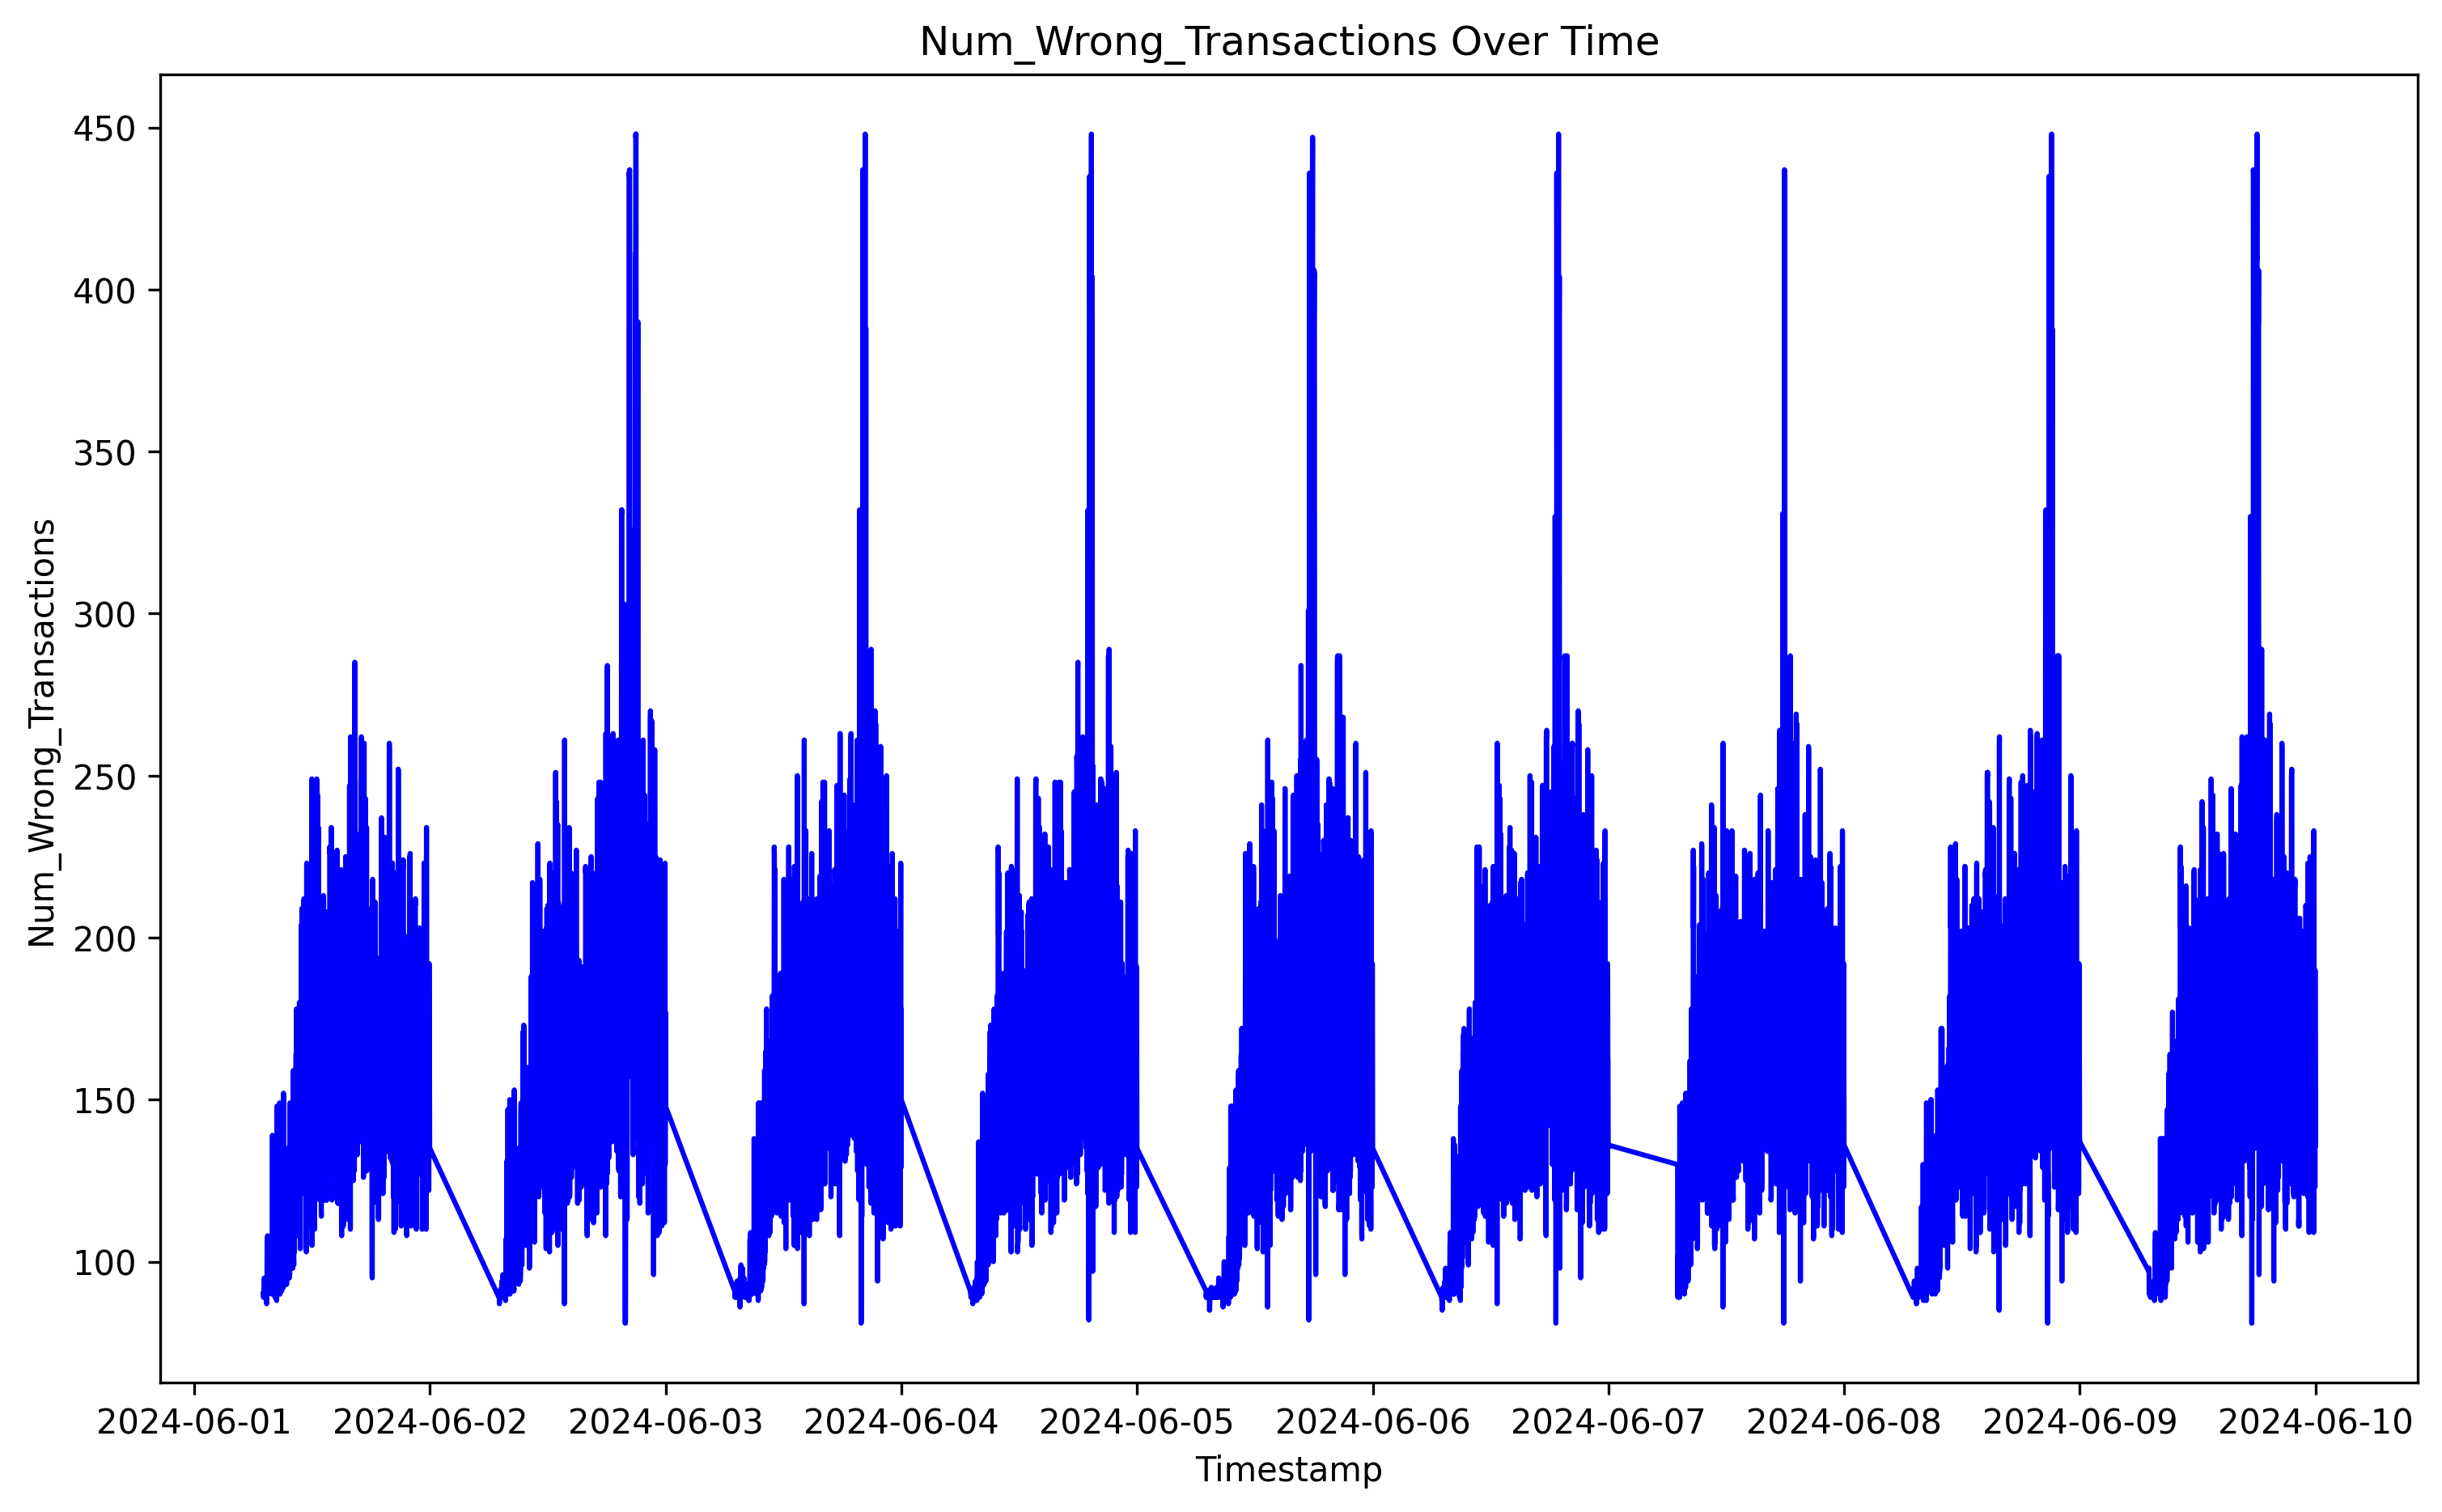

In [11]:
for feat in [
    "Num_Transactions",
    "Time_Max",
    "Time_Min",
    "Mean_Time",
    "Num_Retries",
    "Num_Wrong_Transactions",
]:
    plt.figure()
    plt.plot(gen_data["Timestamp"], gen_data[feat], color="b")
    plt.title(f"{feat} Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel(feat)
    plt.show()

In [ ]:
def augment_windows(X, y, n_augment=2, noise_std=0.01, scale_range=(0.9, 1.1)):
    """
    Given X: (N, w, D), y: (N, D), produces n_augment copies of each
    sample by adding Gaussian noise and a random global scale per feature.
    Returns X_aug: (N*n_augment, w, D), y_aug: (N*n_augment, D).
    """
    N, w, D = X.shape
    X_aug_list = []
    y_aug_list = []
    for _ in range(n_augment):
        # 1) Noise
        noise_X = np.random.normal(0, noise_std, size=(N, w, D))
        noise_y = np.random.normal(0, noise_std, size=(N, D))
        Xn = X + noise_X
        yn = y + noise_y
        # 2) random per-feature scale
        scales = np.random.uniform(scale_range[0], scale_range[1], size=(1, 1, D))
        Xs = Xn * scales
        ys = yn * scales.reshape(1, D)
        X_aug_list.append(Xs)
        y_aug_list.append(ys)
    X_aug = np.concatenate(X_aug_list, axis=0)
    y_aug = np.concatenate(y_aug_list, axis=0)
    return X_aug, y_aug


def train_forecaster(
    df,
    features_to_use,
    window_size=30,
    epochs=20,
    batch_size=16,
    augment=False,
    n_augment=2,
    noise_std=0.01,
    scale_range=(0.9, 1.1),
):
    """
    Trains a multi‐feature LSTM forecaster, with optional data augmentation.

    Arguments:
      df          : pd.DataFrame, DateTimeIndex, D numeric cols
      window_size : int, # of past records to use for each prediction
      features_to_use : list of str, names of columns to use
      epochs      : int
      batch_size  : int
      augment     : bool, whether to augment the X,y windows
      n_augment   : int, # of augmented copies per original sample
      noise_std   : float, std dev of additive Gaussian noise
      scale_range : (low,high), uniform scales applied per feature

    Returns:
      predict_future(past_df, steps) → DataFrame of forecasts
      indexed by future timestamps.
    """
    # 1) timestamp handling
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("`df` must have a DateTimeIndex")
    diffs = df.index.to_series().diff().dropna()
    delta = diffs.median()

    # 2) scale all D columns
    values = df[features_to_use].values  # (N, D)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    N, D = scaled.shape

    # 3) build one-step (X,y)
    X, y = [], []
    print(f"records_per_day: {records_per_day}")
    print(f"window_size: {window_size}")
    print(f"total records: {N}")
    print(f"total days: {N / records_per_day}")
    print(f"total windows: {N - window_size}")
    for i in range(int(N / records_per_day)):
        base = np.max([int(i * records_per_day) - 1, 0])
        print(f"base: {base}")
        for i in range(records_per_day - window_size):
            start_i = base + i
            X.append(scaled[start_i : start_i + window_size, :])  # (w, D)
            y.append(scaled[start_i + window_size, :])  # (D,)
    X = np.stack(X, axis=0)  # (N - ((N / records_per_day) * w), w, D)
    y = np.stack(y, axis=0)  # (N - ((N / records_per_day) * w), D)

    # 4) optionally augment
    if augment:
        X_aug, y_aug = augment_windows(
            X, y, n_augment=n_augment, noise_std=noise_std, scale_range=scale_range
        )
        X = np.concatenate([X, X_aug], axis=0)
        y = np.concatenate([y, y_aug], axis=0)

    # 5) define & train LSTM
    model = models.Sequential(
        [
            layers.LSTM(128, return_sequences=True, input_shape=(window_size, D)),
            layers.LSTM(64, return_sequences=True),
            layers.LSTM(32, activation="tanh"),
            layers.Dense(64, activation="relu"),
            layers.Dense(D),
        ]
    )
    model.compile(optimizer="adam", loss="mae")
    # Plot the training history
    history = model.fit(
        X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2
    )
    # Create subplots side by side
    plt.figure(figsize=(12, 4))
    plt.plot(history.history["loss"], label="train", color="blue")
    plt.plot(history.history["val_loss"], label="validation", color="orange")
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    # 6) forecasting
    def predict_future(past_df, steps):
        """
        Predicts n records into the future, given a past_df of
        window_size rows.
        The predictions are returned as a DataFrame with
        the same columns as the input DataFrame, and the
        index is the future timestamps.

        Arguments:
        past_df  : pd.DataFrame, DateTimeIndex, D numeric cols
        steps    : int, # of records to predict

        Returns:
        DataFrame of forecasts indexed by future timestamps.
        """
        if not isinstance(past_df.index, pd.DatetimeIndex):
            raise ValueError("`past_df` must have a DateTimeIndex")
        if len(past_df) < window_size:
            raise ValueError(f"Need ≥{window_size} rows, got {len(past_df)}")

        arr = past_df[features_to_use].values  # (M, D)
        scaled_arr = scaler.transform(arr)
        window = scaled_arr[-window_size:]  # (w, D)

        preds = []
        for _ in range(steps):
            inp = window.reshape(1, window_size, D)
            nxt = model.predict(inp, verbose=0).reshape(-1)  # (D,)
            preds.append(nxt)
            window = np.concatenate([window[1:], nxt.reshape(1, D)], axis=0)

        # invert & round
        preds = np.stack(preds, axis=0)  # (steps, D)
        inv = scaler.inverse_transform(preds)
        inv = np.rint(inv).astype(int)

        last_ts = past_df.index[-1]
        future_idx = [last_ts + delta * i for i in range(1, steps + 1)]
        return pd.DataFrame(inv, index=future_idx, columns=features_to_use)

    return predict_future


records_per_day: 1018
window_size: 30
total records: 9162
total days: 9.0
total windows: 9132
base: 0
base: 1017
base: 2035
base: 3053
base: 4071
base: 5089
base: 6107
base: 7125
base: 8143


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0525 - val_loss: 0.0429
Epoch 2/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0427 - val_loss: 0.0431
Epoch 3/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0413 - val_loss: 0.0419
Epoch 4/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0398 - val_loss: 0.0400
Epoch 5/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0390 - val_loss: 0.0399
Epoch 6/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0391 - val_loss: 0.0394
Epoch 7/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0385 - val_loss: 0.0400
Epoch 8/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0382 - val_loss: 0.0382
Epoch 9/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0376 - val_loss: 0.0382
Epoch 10/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0371 - val_loss: 0.0375
Epoch 11/180
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0366 - val_loss: 0.0374


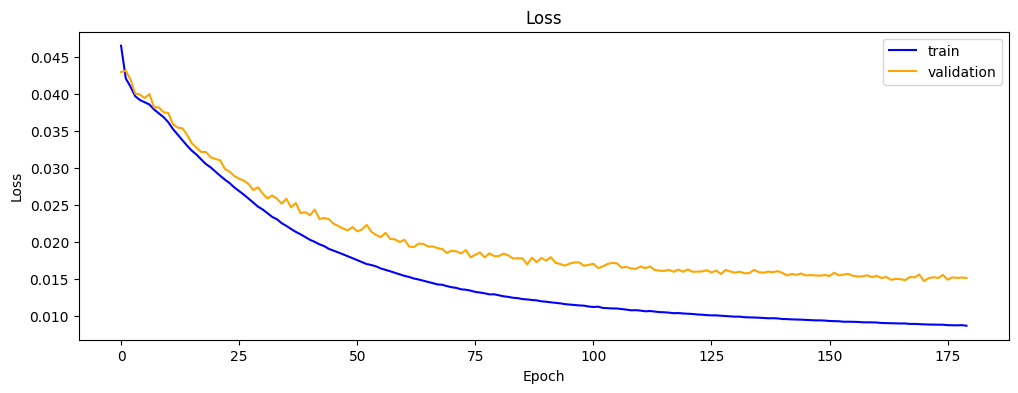

In [ ]:
window_size = 30
epochs = 180

features_to_use = [
    "Num_Transactions",
    "Time_Min",
    "Time_Max",
    "Mean_Time",
    "Num_Retries",
    "Num_Wrong_Transactions",
]

df = pd.concat([raw_df,
                gen_data.iloc[: 8 * 1018]
                ]).set_index("Timestamp")


forecastfn = train_forecaster(
    df,
    features_to_use,
    window_size,
    augment=True,
    epochs=epochs,
    batch_size=16,
)


In [ ]:
pd.concat(
    [raw_df, gen_data.iloc[: 8 * 1018]]
).set_index("Timestamp")

Code_ID  Interval_s  Num_Transactions  Time_Min  \
Timestamp                                                              
2024-05-31 07:01:11        8          60               366         6   
2024-05-31 07:02:11        8          60               948         7   
2024-05-31 07:03:11        8          60              1273         7   
2024-05-31 07:04:11        8          60              1538         6   
2024-05-31 07:05:11        8          60               703         5   
...                      ...         ...               ...       ...   
2024-08-06 23:55:23        8          60              1083         2   
2024-08-06 23:56:23        8          60              1241         2   
2024-08-06 23:57:23        8          60              1239         3   
2024-08-06 23:58:23        8          60              1185         2   
2024-08-06 23:59:23        8          60              1184         2   

                     Time_Max   Mean_Time  Num_Retries  Num_Wrong_Transactions  
Timestamp                                                                       
2024-05-31 07:01:11      1019   25.907562            0                      90  
2024-05-31 07:02:11        90   18.181719            0                      90  
2024-05-31 07:03:11       408   18.813356            0                      90  
2024-05-31 07:04:11        70   16.607435            0                      90  
2024-05-31 07:05:11        85   16.645409            0                      90  
...                       ...         ...          ...                     ...  
2024-08-06 23:55:23        28   15.110000            1                     202  
2024-08-06 23:56:23        28   15.495000            1                     140  
2024-08-06 23:57:23       615  309.045000            0                     140  
2024-08-06 23:58:23        28   15.455000            0                     142  
2024-08-06 23:59:23        28   15.415000            1                     143  

[9162 rows x 8 columns]

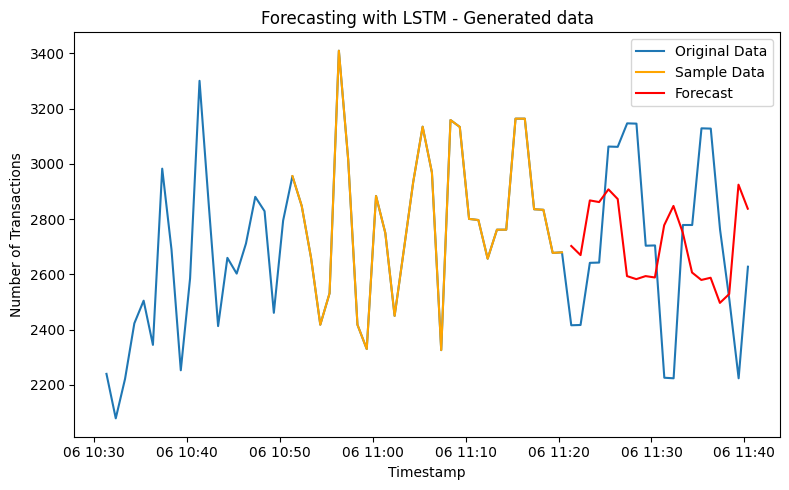

In [ ]:
predict_size = 20

start_point = 230
end_point = start_point + window_size
test_data = gen_data.iloc[8 * 1018:].set_index("Timestamp")
sample_date = test_data[start_point:end_point]
forecast = forecastfn(sample_date, predict_size)


plot_padding = 20
subtest_data = test_data[start_point - plot_padding : end_point + plot_padding]

plt.figure(figsize=(8, 5))
plt.plot(subtest_data.index, subtest_data['Num_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Transactions'], label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Forecasting with LSTM - Generated data')
plt.legend()
plt.tight_layout()
plt.show()


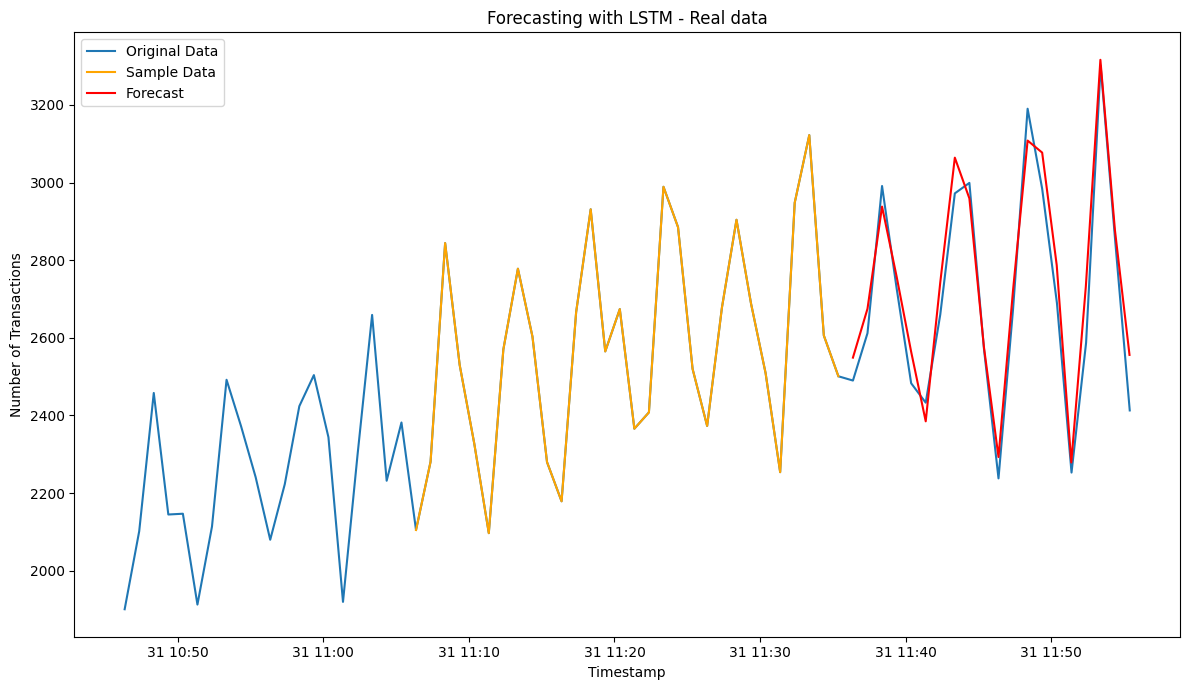

In [ ]:
predict_size = 20

start_point = 245
end_point = start_point + window_size

sample_date = df[start_point:end_point]
forecast = forecastfn(sample_date, predict_size)


plot_padding = 20
subdf = df[start_point - plot_padding : end_point + plot_padding]

plt.figure(figsize=(12, 7))
plt.plot(subdf.index, subdf['Num_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Transactions'], label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Forecasting with LSTM - Real data')
plt.legend()
plt.tight_layout()
plt.show()


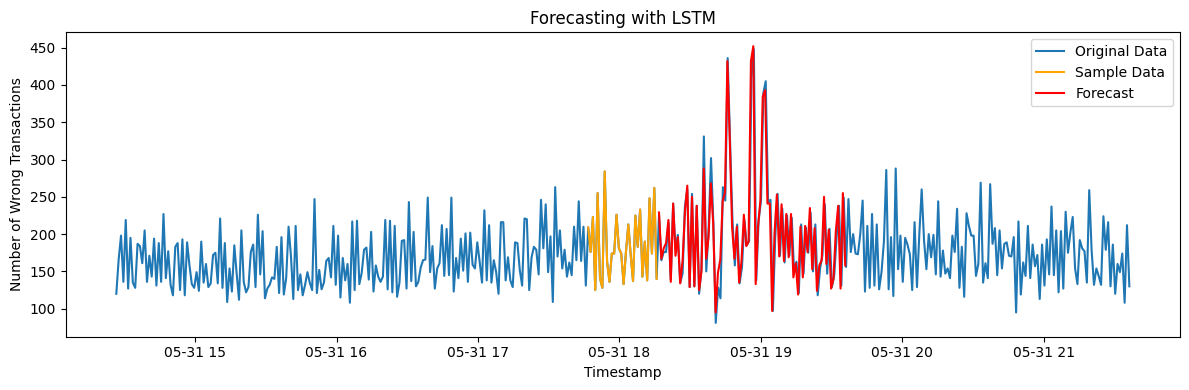

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(subdf.index, subdf['Num_Wrong_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Wrong_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Wrong_Transactions'], label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Number of Wrong Transactions')
plt.title('Forecasting with LSTM')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def augment_points(X, n_augment=2, noise_std=0.01, scale_range=(0.9, 1.1)):
    """
    X: (N, D) array of normalized features.
    Returns n_augment noisy+scaled copies of X, shape (N*n_augment, D).
    """
    N, D = X.shape
    aug_list = []
    for _ in range(n_augment):
        noise = np.random.normal(0, noise_std, size=(N, D))
        Xn = X + noise
        scales = np.random.uniform(scale_range[0], scale_range[1], size=(1, D))
        aug_list.append(Xn * scales)
    return np.vstack(aug_list)


def train_anomaly_detector(
    df,
    features_to_use,
    augment=False,
    n_augment=2,
    noise_std=0.01,
    scale_range=(0.9, 1.1),
    latent_dim=16,
    epochs=20,
    batch_size=32,
):
    """
    Train a point-wise autoencoder on df (must be DateTimeIndex, numeric cols).
    Optionally augment your data. Returns a detect() function.

    detect(pred_df) → DataFrame w/ columns:
      • all original features,
      • recon_error  (MSE per row),
      • is_anomaly   (bool: error > threshold).
    """
    # 1) check and extract
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("`df` must have a DateTimeIndex")
    X_raw = df[features_to_use].values.astype(float)  # shape (N, D)
    N, D = X_raw.shape

    # 2) normalize to [0,1]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X_raw)

    # 3) augment if requested
    if augment:
        X_aug = augment_points(
            X, n_augment=n_augment, noise_std=noise_std, scale_range=scale_range
        )
        X_train = np.vstack([X, X_aug])
    else:
        X_train = X

    # 4) build a simple feed-forward autoencoder
    ae = Sequential(
        [
            layers.Dense(64, activation="relu", input_shape=(D,)),
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(D, activation="sigmoid"),
        ]
    )
    ae.compile(optimizer="adam", loss="mse")
    ae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # 5) set anomaly threshold
    recon = ae.predict(X, verbose=0)
    # per-sample MSE:  MSE_i = (1/D) ∑_j (x_ij - xhat_ij)^2
    mse = np.mean((recon - X) ** 2, axis=1)

    # 6) return detection closure
    def detect(pred_df, threshold_quantile=0.99):
        """
        pred_df: same columns as df, DateTimeIndex, shape (M, D)
        Returns new DataFrame with added columns:
          - recon_error : float
          - is_anomaly  : bool
        """
        thresh = np.quantile(mse, threshold_quantile)
        if not isinstance(pred_df.index, pd.DatetimeIndex):
            raise ValueError("`pred_df` must have a DateTimeIndex")

        Xp_raw = pred_df[features_to_use].values.astype(float)
        Xp = scaler.transform(Xp_raw)
        Xp_hat = ae.predict(Xp, verbose=0)
        err = np.mean((Xp_hat - Xp) ** 2, axis=1)
        out = pred_df.copy()
        out["recon_error"] = err
        out["is_anomaly"] = err > thresh
        return out

    return detect


In [ ]:
# 1. Train on your history
detect = train_anomaly_detector(
    df,
    features_to_use=features_to_use,
    augment=False,
    n_augment=10,
    noise_std=0.02,
    scale_range=(0.9, 1.1),
    latent_dim=4,
    epochs=300,
    batch_size=64,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0962
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0057
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1297e-04
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0502e-04
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2163e-04
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1960e-04
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6222e-04
Epoch 12/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5414e-04
Epoch 13/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4655e-04
Epoch 14/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1236e-04
Epoch 15/30

In [ ]:
# 2. Suppose `forecast_df` is the DataFrame your LSTM forecaster produced:
anomalies_all = detect(df, threshold_quantile=0.988)
print(anomalies_all[anomalies_all.is_anomaly])


                     Code_ID  Interval_s  Num_Transactions  Time_Min  \
Timestamp                                                              
2024-05-31 07:02:11        8          60               948         7   
2024-05-31 07:03:11        8          60              1273         7   
2024-05-31 12:18:26        8          60              3379         0   
2024-05-31 12:21:27        8          60              2577         0   
2024-05-31 12:47:29        8          60              2779         1   
...                      ...         ...               ...       ...   
2024-08-06 16:37:42        8          60              2571         0   
2024-08-06 16:38:42        8          60              2569         0   
2024-08-06 16:51:43        8          60              3972         2   
2024-08-06 16:52:43        8          60              3974         1   
2024-08-06 17:36:45        8          60              3374         1   

                     Time_Max     Mean_Time  Num_Retries  \
Tim

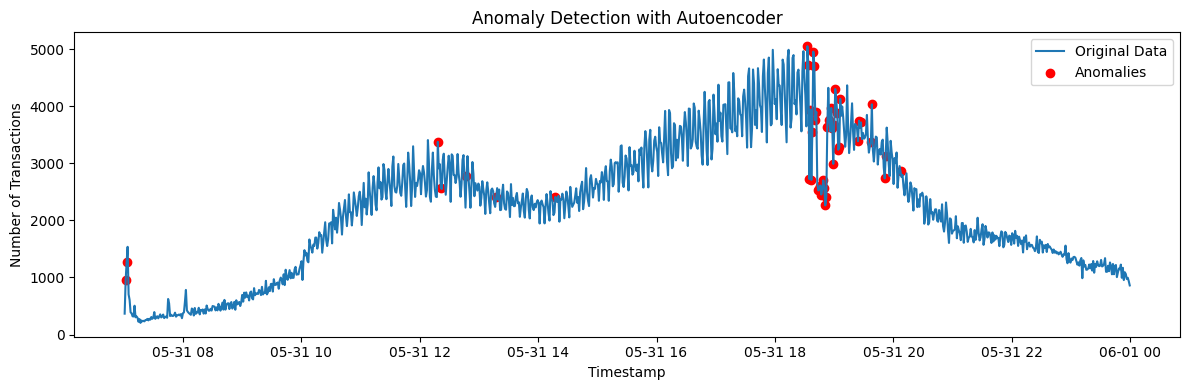

In [ ]:
subdf_for_anomalies_all = df[:1018]
subdf_for_anomalies_all_anoms = anomalies_all[:1018]

# show anomalies with dots
plt.figure(figsize=(12, 4))
plt.plot(subdf_for_anomalies_all.index, subdf_for_anomalies_all['Num_Transactions'], label='Original Data')
plt.scatter(subdf_for_anomalies_all_anoms.index[subdf_for_anomalies_all_anoms.is_anomaly],
            subdf_for_anomalies_all['Num_Transactions'][subdf_for_anomalies_all_anoms.is_anomaly],
            color='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Anomaly Detection with Autoencoder')
plt.legend()
plt.tight_layout()
plt.show()

                     Num_Transactions  Time_Min  Time_Max  Mean_Time  \
2024-05-31 18:28:47              5100         3       363        -41   
2024-05-31 18:34:47              2914         0     21823      -1208   
2024-05-31 18:35:47              3823         0     17382        710   
2024-05-31 18:36:47              2846         0     21489        579   
2024-05-31 18:37:47              3832         0     23958         45   
2024-05-31 18:38:47              4531         0     14253       1434   
2024-05-31 18:39:47              4534         0     10524       1207   
2024-05-31 18:40:47              3647         0      9765         28   
2024-05-31 18:41:47              3781         0     10708      -1061   
2024-05-31 18:42:47              2794         0     30543        819   
2024-05-31 18:43:47              2426         0     50498       2529   
2024-05-31 18:45:47              2710         0     67916       -647   
2024-05-31 18:46:47              2469         0     77892       

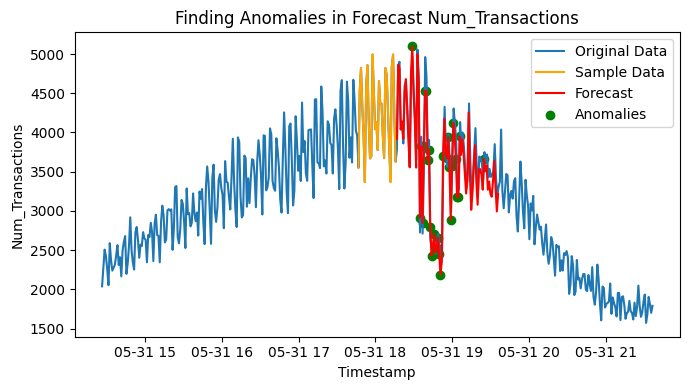

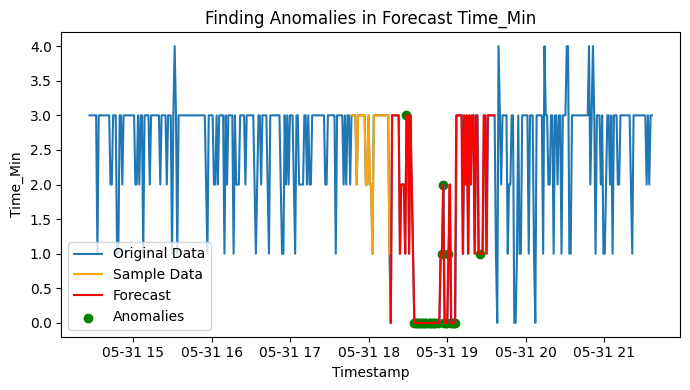

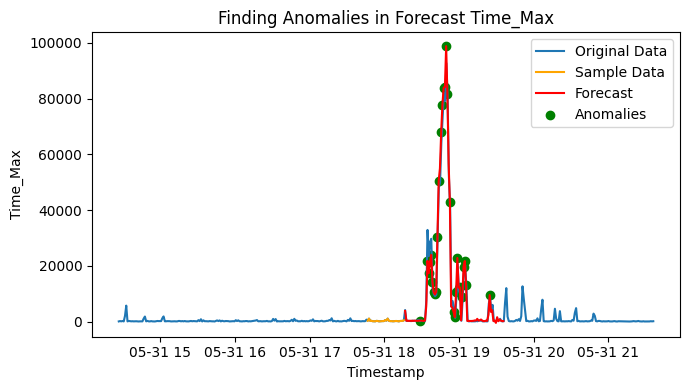

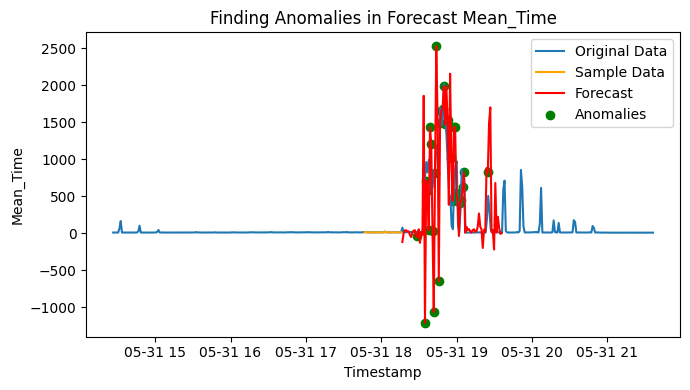

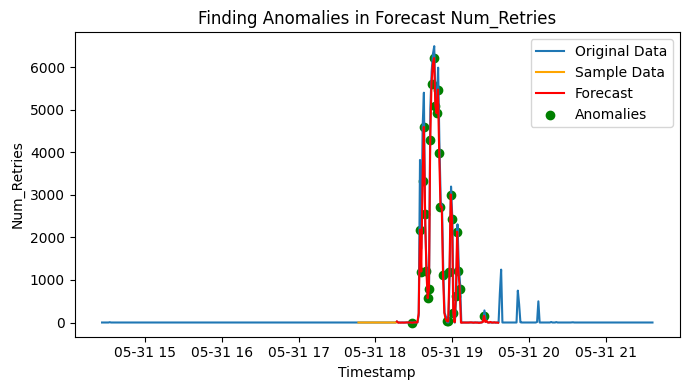

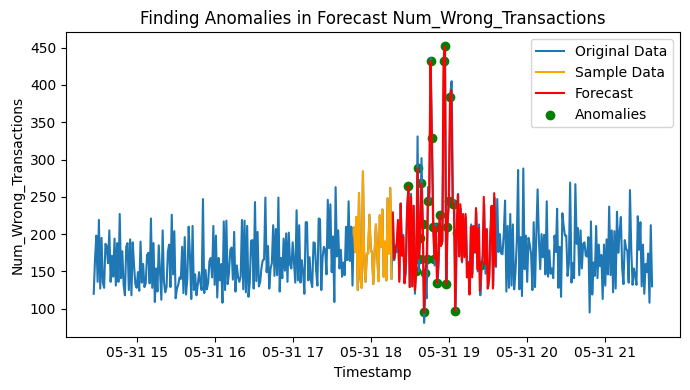

In [ ]:
predict_size = 80

start_point = 645
end_point = start_point + window_size

sample_date = df[start_point:end_point][features_to_use]
forecast = forecastfn(sample_date, predict_size)

anomalies_1 = detect(forecast,threshold_quantile=0.988)
print(anomalies_1[anomalies_1.is_anomaly])

plot_padding = 200
# ! Rename, should not be the same as the one above
subdf = df[start_point - plot_padding : end_point + plot_padding]



for feature in features_to_use:
  plt.figure(figsize=(7, 4))
  plt.plot(subdf.index, subdf[feature], label='Original Data')
  plt.plot(sample_date.index, sample_date[feature], label='Sample Data', color='orange')
  plt.plot(forecast.index, forecast[feature], label='Forecast', color='red')
  plt.scatter(anomalies_1.index[anomalies_1.is_anomaly],
              forecast[feature][anomalies_1.is_anomaly],
              color='green', label='Anomalies')
  plt.xlabel('Timestamp')
  plt.ylabel(feature)
  plt.title(f'Finding Anomalies in Forecast {feature}')
  plt.legend()
  plt.tight_layout()
  plt.show()



Empty DataFrame
Columns: [Num_Transactions, Time_Min, Time_Max, Mean_Time, Num_Retries, Num_Wrong_Transactions, recon_error, is_anomaly]
Index: []


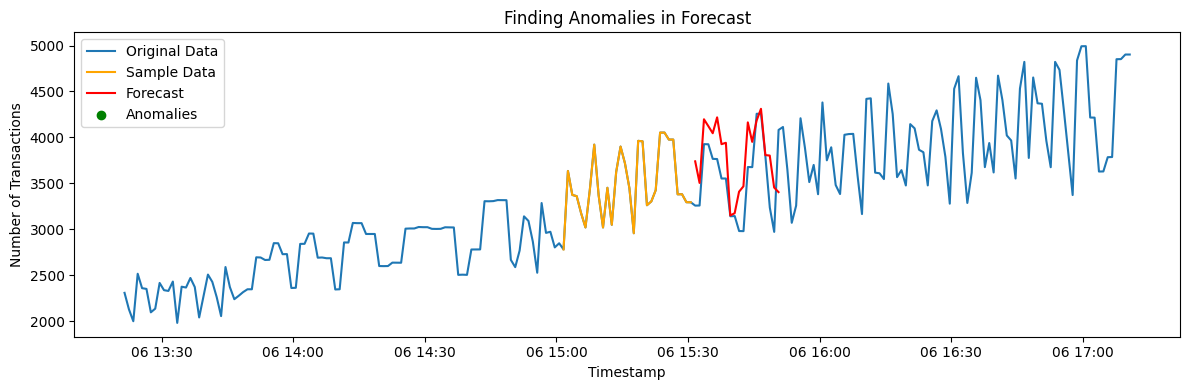

In [ ]:
predict_size = 20

start_point = 480
end_point = start_point + window_size

test_data = gen_data.iloc[8 * 1018:].set_index("Timestamp")[features_to_use]
sample_date = test_data[start_point:end_point]

# sample_date = df[start_point:end_point]
forecast = forecastfn(sample_date, predict_size)

anomalies_2 = detect(forecast,threshold_quantile=0.99)
print(anomalies_2[anomalies_2.is_anomaly])

plot_padding = 100
# ! Rename, should not be the same as the one above
subdf = test_data[start_point - plot_padding : end_point + plot_padding]




plt.figure(figsize=(12, 4))
plt.plot(subdf.index, subdf['Num_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Transactions'], label='Forecast', color='red')
plt.scatter(anomalies_2.index[anomalies_2.is_anomaly],
            forecast['Num_Transactions'][anomalies_2.is_anomaly],
            color='green', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Finding Anomalies in Forecast')
plt.legend()
plt.tight_layout()
plt.show()
